# Setting up the environment

https://community.anaconda.cloud/t/how-do-i-use-an-existing-environment-on-a-new-computer/55641

Load environment with conda
* cd ~/credit-prediction

* conda env create -f environment.yml

(If fist time, install a kernel)

* python -m ipykernel install --user --name=**kernel-name**


Remove kernel from system
* jupyter kernelspec list
* jupyter kernelspec uninstall **kernel-name**

Example code:

conda create --name bjorn-project-env

conda activate bjorn-project-env

conda env create -f environment.yml

python -m ipykernel install --user --name=bjorn-project-kernel





## Additional notes:
Create venv able with kernel:
* conda env export > environment.yml

Project description:

Each workbook contains the result of experiment 1,2,3 for 1 dataset.
The structure of the workbook is as follows:
* 

The credit dataset is provided by Home Credit Group on Kaggle:
https://www.kaggle.com/competitions/home-credit-default-risk/overview

The workbook is divided into five section:
* Importing the data
* Define the preprocessing steps
* Define the classifiers used in the experiment
* Building the pipeline (by combining the definition in the previous two steps)
* Model training and tuning
* Model evaluation

This workbook build upon the work of the EDA performed in:
https://colab.research.google.com/drive/1-tPYsMyIGJWiXSGJi9nqbfjkbu075tmJ?usp=sharing
Only the general results of this EDA will be visualised in this notebook. For a more elaborate understanding of the dataset, please visit the link stated above.


Todo list: 


- update packages to recent versions
- clean up deprecated parts
- shared .py with the logic of the pipeline inside of it
- remove create.... and instead have them all in the pipeline
- look at visualisation and see if they are generic enough
- saving results need to be more scalable

In [3]:
# enable auto reload, info: https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import pprint

/tmp/ipykernel_634/232977425.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
show_versions = True
if show_versions:
  %pip freeze | grep 'pandas\|matplotlib\|numpy\|seaborn\|scikit-learn\|imbalanced-learn'
else:
  #at least required in order to run:
  print("YOU NEED AT LEAST THESE VERSION IN ORDER TO RUN THE NOTEBOOK")
  pprint.pprint(['imbalanced-learn==0.12.0',
'matplotlib==3.8.2',
'matplotlib-inline @ file:///home/conda/feedstock_root/build_artifacts/matplotlib-inline_1660814786464/work',
'numpy==1.26.3',
'pandas==2.2.0',
'scikit-learn==1.4.0',
'seaborn==0.13.2',
'Note: you may need to restart the kernel to use updated packages.'])

imbalanced-learn==0.12.0
matplotlib==3.8.2
matplotlib-inline==0.1.6
numpy==1.26.3
pandas==2.2.0
scikit-learn==1.4.0
seaborn==0.13.2
Note: you may need to restart the kernel to use updated packages.


# Importing dataset and combining tables
the original dataset source and problem description can be found on:
https://www.kaggle.com/datasets/mamtadhaker/lt-vehicle-loan-default-prediction


# Random State

In [6]:
# reason for randomstate initialisation:
# For these reasons, it is preferable to evaluate the cross-validation performance by 
# letting the estimator use a different RNG on each fold. This is done by passing a RandomState 
# instance (or None) to the estimator initialization.
#...
#When we pass an integer, the estimator will use the same RNG on each fold: 
#if the estimator performs well (or bad), as evaluated by CV, it might just 
#be because we got lucky (or unlucky) with that specific seed. 
#Passing instances leads to more robust CV results, and makes the comparison between various algorithms fairer. 

# Since a RandomState instance was passed to a, a and b are not clones in the strict sense, 
# but rather clones in the statistical sense: a and b will still be different models,
# even when calling fit(X, y) on the same data. Moreover, a and b will influence each-other 
# since they share the same internal RNG: calling a.fit will consume b’s RNG, 
# and calling b.fit will consume a’s RNG, since they are the same. This bit is true for any estimators 
# that share a random_state parameter; it is not specific to clones.

# Warning Even though clone is rarely used in user code, it is called pervasively throughout scikit-learn codebase: 
# in particular, most meta-estimators that accept non-fitted estimators call clone internally 
#  (GridSearchCV, StackingClassifier, CalibratedClassifierCV, etc.).

rng_tensor_df = np.random.RandomState(0)
rng_lgbm = np.random.RandomState(1)
catboost_seed_num = 2
rng_rf = np.random.RandomState(3)
#Note We do not recommend setting the global numpy seed by calling np.random.seed(0). See here for a discussion.
#https://stackoverflow.com/questions/5836335/consistently-create-same-random-numpy-array/5837352#comment6712034_5837352


#the model is shared across experiment:
#the reason for recreating is that on each experiment the estimator might get changed internally
#by something for the pipeline

# Classifiers
Define the classifiers used for this dataset

### LightGBM

In [7]:
from lightgbm import LGBMClassifier
import joblib
#https://scikit-learn.org/stable/modules/calibration.html

#LightGBM
# https://towardsdatascience.com/lightgbm-with-the-focal-loss-for-imbalanced-datasets-9836a9ae00ca
# another option would be to use focall loss
def create_lightgbm_model():
  params = {'objective': 'binary'}
  lgbm = LGBMClassifier(**params, max_depth=10, random_state=rng_lgbm, n_jobs=1, verbose=-1)
  return lgbm
  # lgbm.fit(x_train, y_train);

  # lgbm, lgbm_report = report(lgbm, x_train, y_train,
  #                                x_test, y_test,
  #                                display_scores=[primary_eval_metric],
  #                                importance_plot=True,
  #                                feature_labels=feature_names,
  #                                confusion_labels=confusion_lbs)

  #train the models on the train data

### Catboost

In [8]:
from catboost import CatBoostClassifier

# If any features in the cat_features parameter are specified as names instead of indices,
#  feature names must be provided for the training dataset. Therefore, the type of 
#  the X parameter in the future calls of the fit function must be either catboost.Pool 
#  with defined feature names data or pandas.DataFrame with defined column names.

#for some reason random_state is not working like I expect for cat_boost
def create_catboost_model():
  cat_boost = CatBoostClassifier(thread_count=1, 
                                 random_seed=catboost_seed_num, 
                                 depth=6, #is the default 
                                 verbose=False, 
                                 n_estimators=100,
                                 boosting_type='Plain', #default
                                 leaf_estimation_iterations=1,
                                 min_child_samples=20, #just like lightgbm
                                 # bootstrap_type='MVS' #cpu only
                                )
  return cat_boost
# https://medium.com/analytics-vidhya/combining-scikit-learn-pipelines-with-catboost-and-dask-part-2-9240242966a7

## Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

def create_random_forest_model():
  rf = RandomForestClassifier(n_jobs=1, max_depth=16, random_state=rng_rf)
  return rf

# Metrics
Define the metrics used for this dataset

In [10]:
from common_evaluation_metrics import accuracy_scorer, roc_auc_scorer, weighted_average_recall_scorer, fmeasure_scorer, cohen_kappa_scorer

# EVALUATION_METRICS (ONLY PERFORMANCE FOR NOW)
evaluation_metrics = {
  "accuracy_score": accuracy_scorer, 
  "roc_auc": roc_auc_scorer, 
  "weighted_average_recall": weighted_average_recall_scorer, 
  "f_score": fmeasure_scorer, 
  "kappa": cohen_kappa_scorer,
  # "balanced_acc_sklearn": balanced_accuracy_sklearn_scorer, 
  # "spd_gender": neg_abs_spd_loss_GENDER_scorer,
  # 'eod_gender': neg_abs_eod_loss_GENDER_scorer, 
  # 'spd_education': neg_abs_spd_loss_EDUCATION_scorer, 
  # 'eod_education': neg_abs_eod_loss_EDUCATION_scorer, 
  # 'spd_region': neg_abs_spd_loss_REGION_scorer, 
  # 'eod_region': neg_abs_eod_loss_REGION_scorer
}

In [11]:
#CONTROLLING RANDOMNESS
#the following was said:
#Whether we pass RandomState instances or integers to CV splitters 
#has no impact on robustness, as long as split is only called once. 
#When split is called multiple times, fold-to-fold comparison isn’t possible anymore. 
#As a result, passing integer to CV splitters is usually safer and covers most use-cases.
global RANDOM_SPLIT_STATE
#determined by doing np.random.randint(1000) once
#kept the same so that possible reruns will have the same split_state
RANDOM_SPLIT_STATE = 233
#In this experiment stratified k-fold cross validation will be applied to all models
#during the gridsearch. The models themselve have a randomness in their random_state.
#However, when the performance is compared between each different type of model
#we want each type of model to have the same splits. Otherwise: as luck would have it
#one specific type of model might have had better splits then others. Therefore, I do not 
#treat the random_split_state as a hyperparamater but the same split state is used
#across all models grid_searches.

# Dataset of Banking Dataset - L&T Vehicle Loan Default Prediction

## Combining multiple tables into one
The information from all tables with be combined into one used for the machine learning training process

In [12]:
def hasAllFeaturesIncluded(df_columns, *args):
  total_length = 0
  
  for arg in args:
    if not np.isin(arg, df_columns).all():
      # print('args: ', args)
      # print('arg: ', arg)
      # print('cols: ', df_columns)
      raise Exception(pd.DataFrame({'col': arg, 'result': np.isin(arg, df_columns)}))
    total_length += len(arg)
    
  if total_length != len(df_columns):
    df_bug = pd.DataFrame({'col': df_columns, 'result': np.isin(df_columns, sum(args,[]))})
    print(df_bug.loc[(df_bug['result'] == False)])
    raise Exception(f'Not all features are included: total_length, df_length: {total_length} and {len(df_columns)}')
  return True

In [13]:
# import os
# dataset_folder_name = "lt-vehicle-loan-default-prediction"
# folder_location = os.path.join(os.getcwd(), "data", dataset_folder_name)
# file_location = os.path.join(folder_location, "train.csv")

# #NOT SURE IF THIS WILL WORK SINCE IT IS A TEXT FILE
# RAW_application_train_dataset = pd.read_csv(file_location)

In [14]:
# defines all the feature name by either numerical, or categorical (nonminal / ordinal)
def getFeatureNamesGroupedPerType(df_columns, dropped_col_names=[]):
  #The original devision of predictor value types (e.g. continuous, discrete, nominal, ordinal)
  #no quantitative data is present
  
  #the input features are seperated into nominal, ordinal, interval and continuous
  # NOMINAL
  # NOTE: THE FOLLOWING THREE 'MODE' ARE CATEGORICAL DATA, BUT HAVE BEEN MISLABBELED
  # AS MODE
  # - FONDKAPREMONT_MODE
  # - HOUSETYPE_MODE
  # - WALLSMATERIAL_MODE
  # - EMERGENCYSTATE_MODE
  nominal_features = ['branch_id', 
                      'supplier_id', 
                      'manufacturer_id', 
                      'Current_pincode_ID',
                      'Employment.Type',
                      'Employee_code_ID',
                      'MobileNo_Avl_Flag',
                      'Aadhar_flag',
                      'PAN_flag',
                      'Driving_flag',
                      'Passport_flag',
                      'VoterID_flag',
                      'PERFORM_CNS.SCORE.DESCRIPTION', # is kind of ordinal if you group Not Scored together (however will drop this, so no need)
                      'AVERAGE.ACCT.AGE.Mapped'
                     ]
  
  # [
  #   'job',
  #   'marital',
  #   'housing',
  #   'loan',
  #   'contact',
  #   'month', #do not want to define the months in ordinal and will be removed
  #   'poutcome',
  #   'default'
  # ]
  # ORDINAL
  
#   education_categories_ordered = ['unknown', 'primary', 'secondary','tertiary']

  ordinal_features_dict = {
  }
  
  # INTERVAL
  discrete_features = [
    'PERFORM_CNS.SCORE', 
    'PRI.NO.OF.ACCTS', 
    'PRI.ACTIVE.ACCTS',
    'PRI.OVERDUE.ACCTS',
    'PRI.CURRENT.BALANCE',
    'PRI.SANCTIONED.AMOUNT',
    'SEC.NO.OF.ACCTS',
    'SEC.ACTIVE.ACCTS',
    'SEC.OVERDUE.ACCTS',
    'NEW.ACCTS.IN.LAST.SIX.MONTHS',
    'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
    'AVERAGE.ACCT.AGE',
    'CREDIT.HISTORY.LENGTH',
    'NO.OF_INQUIRIES',
    'Year_of_Birth', #engineered
    'State_ID'
  ]
  
  # ['age', 'day', 'duration', 'campaign', 'pdays', 'previous']
  # CONTINUOUS
  continuous_features = [
    'disbursed_amount',
    'asset_cost',
    'ltv',
    'Date.of.Birth',
    'DisbursalDate',
    'PRI.DISBURSED.AMOUNT',
    'SEC.CURRENT.BALANCE',
    'SEC.SANCTIONED.AMOUNT',
    'SEC.DISBURSED.AMOUNT',
    'PRIMARY.INSTAL.AMT',
    'SEC.INSTAL.AMT',
    
  ]
  # ['balance']
  
  original_length = len(nominal_features) + len(list(ordinal_features_dict.keys())) + len(discrete_features) + len(continuous_features)

  pprint.pprint({
    'total_num_of_features_in_raw_dataset': original_length,
    'dropped_features': len(dropped_col_names),
    'total_num_of_features_in_final_dataset': original_length - len(dropped_col_names)
  })
  
  for dropped_col in dropped_col_names:
    if dropped_col in nominal_features:
      nominal_features.remove(dropped_col)
    elif dropped_col in ordinal_features_dict:
      removed_value = ordinal_features_dict.pop(dropped_col)
      print(f'ordinal col is removed with: {dropped_col}, {removed_value}')
    elif dropped_col in discrete_features:
      discrete_features.remove(dropped_col)
    elif dropped_col in continuous_features:
      continuous_features.remove(dropped_col)
    else:
      raise Exception('Unable to find dropped col ' + dropped_col)
  
  
  #perform check to make sure
  if not hasAllFeaturesIncluded(df_columns, nominal_features, list(ordinal_features_dict.keys()), discrete_features, continuous_features):
    raise Exception('error in config of features')
  
  return nominal_features, ordinal_features_dict, discrete_features, continuous_features

In [15]:
# @Deprecated
# def changeColTypesOfDataframe(raw_data, LOCAL_nominal_application_features, LOCAL_ordinal_application_features_grouped_order_info):
#     #import categorical dtype
#     from pandas.api.types import CategoricalDtype
#     #after reading in the data, the data should be labbeled correctly
#     #https://books.google.nl/books?hl=en&lr=&id=F7zADwAAQBAJ&oi=fnd&pg=PP1&dq=Data+Science+and+Machine+Learning:+Mathematical+and+Statistical+Methods&ots=C_IlHtn8sH&sig=THDfZV5_uUtj3DeeapmZwydBHQM&redir_esc=y#v=onepage&q=Data%20Science%20and%20Machine%20Learning%3A%20Mathematical%20and%20Statistical%20Methods&f=false
#     #see 1.2 of above book

#     #NOTE MAYBE A BETTER SPLIT IS : NOMINAL, ORDINAL, INTERVAL AND RATIO
#     #https://towardsdatascience.com/data-preprocessing-concepts-fa946d11c825
    
#     cols = raw_data.columns

#     dTypeMapping = {}
#     for feature in LOCAL_nominal_application_features:
#       if feature in cols:
#         dTypeMapping[feature] = 'category'

#     for feature in LOCAL_ordinal_application_features_grouped_order_info:
#       if feature["columnName"] in cols:
#         pandasOrdinalType =CategoricalDtype(categories=feature["categories"], ordered=True)
#         dTypeMapping[feature["columnName"]] = pandasOrdinalType

#     #the int and floats will be converted after the missing values have been handled
#     return raw_data.astype(dTypeMapping)
from common_ml_pipeline import check_allowed_json_character_in_col_names_lightgbm


def loadDataset():
  dataset_folder_name = "lt-vehicle-loan-default-prediction"
  folder_location = os.path.join(os.getcwd(), "data", dataset_folder_name)
  file_location = os.path.join(folder_location, "train.csv")

  #
  RAW_application_train_dataset = pd.read_csv(file_location)
  
  # RAW_application_test_dataset = pd.read_csv("application_test.csv")
  # RAW_bureau_dataset = pd.read_csv(root_data_path + "/bureau.csv")
  # RAW_bureau_balance_dataset = pd.read_csv(root_data_path + "/bureau_balance.csv")
  # RAW_pos_cash_balance_dataset = pd.read_csv(root_data_path + "/POS_CASH_balance.csv")
  # RAW_credit_card_balance_dataset = pd.read_csv(root_data_path + "/credit_card_balance.csv")
  # RAW_previous_application_dataset = pd.read_csv(root_data_path + "/previous_application.csv")
  # RAW_installments_payments_dataset = pd.read_csv(root_data_path + "/installments_payments.csv")
  #TEMP
  combined_train_dataset = RAW_application_train_dataset
  
  # Define the types of the columns
  #all the target features
  target_features = ['loan_default']
  # ['y']
  
  # DEPRECATED IN V3
  # combined_train_dataset_typed = changeColTypesOfDataframe(combined_train_dataset, RAW_nominal_application_features, RAW_ordinal_application_features_grouped_order_info)
  # combined_test_dataset_typed = changeColTypesOfDataframe(combined_test_dataset, RAW_nominal_application_features, RAW_ordinal_application_features_grouped_order_info)
  
  #recoded the AVERAGE.ACCT.AGE (longer than 1 year is 1, shorter is 0
  mask_average_act_age = combined_train_dataset['AVERAGE.ACCT.AGE'].str.match('[1-9].*yrs .*')
  combined_train_dataset['AVERAGE.ACCT.AGE.Mapped'] = mask_average_act_age.map({True: 1, False: 0})
  
  
  # Extracted the year out of the Date of Birth (Date of Birth will be discarded)
  combined_train_dataset['Year_of_Birth'] = pd.to_datetime(combined_train_dataset['Date.of.Birth'], format='%d-%m-%y').dt.year
  
  # Dropping features based on prior correlation analysis
  #day and month: https://www.kaggle.com/code/tirsogomez/banking-dataset-analysis
  cat_features_dropped = ['PERFORM_CNS.SCORE.DESCRIPTION', 'branch_id', 'supplier_id', 'manufacturer_id', 
                          'Current_pincode_ID', 'Employee_code_ID',
                         ]
  #['month']
  num_features_dropped = ['PERFORM_CNS.SCORE', 'CREDIT.HISTORY.LENGTH', 'Date.of.Birth', 'DisbursalDate', 'AVERAGE.ACCT.AGE']
  #['day']

  all_features_dropped_based_analysis = [*cat_features_dropped, *num_features_dropped]
  final_train_dataset = combined_train_dataset.drop(columns=all_features_dropped_based_analysis)
  # final_test_dataset_typed = combined_test_dataset_typed.drop(columns=all_features_dropped)
  
  
  pprint.pprint({
    'feature_drop_length': len(cat_features_dropped) + len(num_features_dropped),
    'feature_final_dataset_length': len(final_train_dataset.columns),
    'feature_first_dataset_length': len(combined_train_dataset.columns)
  })
  
  if len(cat_features_dropped) + len(num_features_dropped) + len(final_train_dataset.columns) != len(combined_train_dataset.columns):
    raise Exception("something went wrong when dropping the columns")
  

  #index 0 is the id and should not be included
  #dropping the SK_ID_CURR for training (only needed for merging)
  X = final_train_dataset.drop(columns=['UniqueID', 'loan_default']) #final_train_dataset.drop(columns=['SK_ID_CURR', 'TARGET'])
  y = final_train_dataset['loan_default']
  
  dropped_cols_based_on_missing_values = X.columns[(X.isna().sum() / len(X) > 0.1) == True]
  
  X = X.drop(columns=dropped_cols_based_on_missing_values)
  
  all_features_dropped = [*all_features_dropped_based_analysis, *dropped_cols_based_on_missing_values]

    
  #NEW IN V3 (INSTEAD OF USING THE COLTYPE NOW THE FEATURE NAMES ARE USED IN THE PIPELINE)
  nominal_features, ordinal_features_dict, discrete_features, continuous_features = getFeatureNamesGroupedPerType(df_columns=X.columns, dropped_col_names=all_features_dropped)
  
  #lightgbm does not except certain JSON characters
  valid, not_allowed_dict = check_allowed_json_character_in_col_names_lightgbm(X.columns)
  if not valid:
    pprint.pprint(not_allowed_dict)
    raise Exception('please change the columns with the unallowed chars')
  
  return X, y, nominal_features, ordinal_features_dict, discrete_features, continuous_features

In [16]:
X, y, nominal_features, ordinal_features_dict, discrete_features, continuous_features = loadDataset()

{'feature_drop_length': 11,
 'feature_final_dataset_length': 32,
 'feature_first_dataset_length': 43}
{'dropped_features': 11,
 'total_num_of_features_in_final_dataset': 30,
 'total_num_of_features_in_raw_dataset': 41}


In [17]:
# #TEMP TO TEST THE NEW SETUP OF V3
# X = X.head(100000)
# y = y.head(100000)

## Splitting features/target
Note: The test data is already split from this dataset and provided in application_test.csv

In [18]:
def compute_oversampling_ratio(y, percentage_increase):
  majority_counts, minority_counts = np.bincount(y)
  multiplier = 1 + (percentage_increase/100)
  new_minority_counts = minority_counts * multiplier
  desired_ratio = new_minority_counts / majority_counts
  return desired_ratio

# def compute_undersampling_ratio(y, modifier):
#   majority_counts, minority_counts = np.bincount(y)
#   if modifier < 0 or modifier > 1:
#     raise Exception("modifier should be between 0 and 1, but modifier input is: ", modifier)     
  

# only for two class problem
def compute_balanced_class_weight(y, modifier):
  #balanced weight are based on the sklearn implementation:
  #n_samples / (n_classes * np.bincount(y))
  #the modifier can have a value between 0 and 1
  if modifier < 0 or modifier > 1:
    raise Exception("modifier should be between 0 and 1, but modifier input is: ", modifier)
  n_classes = 2
  n_samples = len(y)
  counts_per_class = np.bincount(y)
  if len(counts_per_class) != 2:
    raise Exception("please provide a y with only 0 and 1 values ")
  balanced_majority, balanced_minority = n_samples/(n_classes*counts_per_class)
  modified_balanced_majority = balanced_majority + (1-balanced_majority)*modifier
  modified_balanced_minority = balanced_minority - (balanced_minority-1)*modifier
  return {0: modified_balanced_majority, 1: modified_balanced_minority}

In [19]:
from sklearn.model_selection import RepeatedStratifiedKFold

#experimental set-up
#the ratio will be preserved since the stratified cross validation will be applied
#so the ratio of the split will be the same as the subset
# NOTE: PERCENTAGE CHANGED BECAUSE THERE WAS LESS IMBALANCE IN THE DATASET
over_50 = compute_oversampling_ratio(y=y, percentage_increase=50)
over_100 = compute_oversampling_ratio(y=y, percentage_increase=100)
over_150 = compute_oversampling_ratio(y=y, percentage_increase=150)
over_200 = compute_oversampling_ratio(y=y, percentage_increase=200)

all_over_sampling_except_0 = [over_50, over_100, over_150, over_200]

#the ratio will be preserved since the stratified cross validation will be applied
#so the ratio of the split will be the same as the subset
class_weight_none = compute_balanced_class_weight(y=y, modifier=1) #--> {majority_class: 1, minority_class: 1} --> no weights
class_weight_little = compute_balanced_class_weight(y=y, modifier=3/4) #--> {majority_class: 0.885457303857824, minority_class: 2.369170984455959}
class_weight_moderate = compute_balanced_class_weight(y=y, modifier=2/4) #--> {majority_class: 0.770914607715648, minority_class: 3.738341968911917}
class_weight_high = compute_balanced_class_weight(y=y, modifier=1/4) #--> {majority_class: 0.6563719115734721, minority_class: 5.107512953367875}
class_weight_fully_balanced = compute_balanced_class_weight(y=y, modifier=0) #--> {majority_class: 0.54182922, minority_class: 6.47668394} --> weighed based on imbalance in original train data

all_class_weights = [class_weight_none, class_weight_little, class_weight_moderate, class_weight_high, class_weight_fully_balanced]

#the second experiment will vary the undersampling ratio
under_ratio_50 = over_200 #--> 33%
under_ratio_balanced = 1 #--> 50%
under_ratio_low = (1/4)*(under_ratio_balanced-under_ratio_50) + under_ratio_50
under_ratio_middle = (2/4)*(under_ratio_balanced-under_ratio_50) + under_ratio_50
under_ratio_high = (3/4)*(under_ratio_balanced-under_ratio_50) + under_ratio_50

all_undersampling_ratios = [under_ratio_50, under_ratio_low, under_ratio_middle, under_ratio_high, under_ratio_balanced]

# param_grid_experiment = {
#     'oversample__sampling_strategy': [over_400],
#     'classifier__class_weight': [class_weight_none, class_weight_fully_balanced]
# }

In [21]:
# PIPELINE TESTING
# from common_ml_pipeline import build_preprocessing_steps
# from imblearn.pipeline import Pipeline as Imblearn_Pipeline

# preprocessing_steps = build_preprocessing_steps(nominal_features, ordinal_features_dict, discrete_features, continuous_features)

# imblearn_preprocessing_pipeline = Imblearn_Pipeline(steps=[*preprocessing_steps])
# # print("********pipeline_build...")
# imblearn_preprocessing_pipeline.set_output(transform='pandas')
    
# # pipeline = build_pipeline('passthrough', nominal_features, ordinal_features_dict, discrete_features, continuous_features)

# result = imblearn_preprocessing_pipeline.fit(X, y)

In [22]:
# credits: https://stackoverflow.com/questions/5194057/better-way-to-convert-file-sizes-in-python

UNITS_MAPPING = [
    (1<<50, ' PB'),
    (1<<40, ' TB'),
    (1<<30, ' GB'),
    (1<<20, ' MB'),
    (1<<10, ' KB'),
    (1, (' byte', ' bytes')),
]


def pretty_size(bytes, units=UNITS_MAPPING):
    """Get human-readable file sizes.
    simplified version of https://pypi.python.org/pypi/hurry.filesize/
    """
    for factor, suffix in units:
        if bytes >= factor:
            break
    amount = int(bytes / factor)

    if isinstance(suffix, tuple):
        singular, multiple = suffix
        if amount == 1:
            suffix = singular
        else:
            suffix = multiple
    return str(amount) + suffix

In [21]:
import sys
pretty_size(sys.getsizeof(X) + sys.getsizeof(y))

'67 MB'

## Experiment 1

In [26]:
from common_experiments import perform_experiment_1

pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


In [28]:
dataset_size_GB = 0.5

### rf

In [ ]:
%%time
grid_search_experiment_1_rf = perform_experiment_1(
  estimator=create_random_forest_model(), 
  X=X, 
  y=y,
  evaluation_metrics=evaluation_metrics,
  random_state=RANDOM_SPLIT_STATE, 
  all_class_weights=all_class_weights, 
  all_over_sampling_except_0=all_over_sampling_except_0,
  nominal_features=nominal_features, 
  ordinal_features_dict=ordinal_features_dict, 
  discrete_features=discrete_features, 
  continuous_features=continuous_features,
  dataset_size_GB=dataset_size_GB
)

total jobs for gridsearch are: 90
{'availabe_cpu': 112,
 'available_virtual_memory': 234,
 'max_n_jobs_cpu_bound': 112,
 'max_n_jobs_memory_bound': 468}
{'n_jobs': 90, 'pre_dispatch': '2*n_jobs'}


### lightgbm

In [39]:
%%time
grid_search_experiment_1_lightgbm = perform_experiment_1(
  estimator=create_lightgbm_model(), 
  X=X, 
  y=y,
  evaluation_metrics=evaluation_metrics,
  random_state=RANDOM_SPLIT_STATE, 
  all_class_weights=all_class_weights, 
  all_over_sampling_except_0=all_over_sampling_except_0,
  nominal_features=nominal_features, 
  ordinal_features_dict=ordinal_features_dict, 
  discrete_features=discrete_features, 
  continuous_features=continuous_features,
  dataset_size_GB=dataset_size_GB
)

total jobs for gridsearch are: 90
{'availabe_cpu': 112,
 'available_virtual_memory': 232,
 'max_n_jobs_cpu_bound': 112,
 'max_n_jobs_memory_bound': 464}
{'n_jobs': 90, 'pre_dispatch': '2*n_jobs'}
CPU times: user 27.6 s, sys: 2min 3s, total: 2min 30s
Wall time: 21min 44s


### catboost

In [42]:
%%time
grid_search_experiment_1_catboost = perform_experiment_1(
  estimator=create_catboost_model(),
  X=X, 
  y=y,
  evaluation_metrics=evaluation_metrics,
  random_state=RANDOM_SPLIT_STATE, 
  all_class_weights=all_class_weights, 
  all_over_sampling_except_0=all_over_sampling_except_0,
  nominal_features=nominal_features, 
  ordinal_features_dict=ordinal_features_dict, 
  discrete_features=discrete_features, 
  continuous_features=continuous_features, 
  dataset_size_GB=dataset_size_GB
)

total jobs for gridsearch are: 90
{'availabe_cpu': 112,
 'available_virtual_memory': 231,
 'max_n_jobs_cpu_bound': 112,
 'max_n_jobs_memory_bound': 462}
{'n_jobs': 90, 'pre_dispatch': '2*n_jobs'}


/opt/miniconda3/envs/bjorn-project-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 1min 8s, sys: 3min 16s, total: 4min 24s
Wall time: 24min 47s


## Experiment 2 - undersampling
Procedure:

In [44]:
from common_experiments import perform_experiment_2
dataset_size_GB = 0.1

### rf

In [45]:
%%time
grid_search_experiment_2_rf = perform_experiment_2(
  estimator=create_random_forest_model(), 
  X=X, 
  y=y, 
  random_state=RANDOM_SPLIT_STATE, 
  evaluation_metrics=evaluation_metrics, 
  all_undersampling_ratios=all_undersampling_ratios, 
  all_over_sampling_except_0=all_over_sampling_except_0, 
  class_weight_none=class_weight_none,
  nominal_features=nominal_features, 
  ordinal_features_dict=ordinal_features_dict, 
  discrete_features=discrete_features, 
  continuous_features=continuous_features,   
  dataset_size_GB=dataset_size_GB
)

total jobs for gridsearch are: 90
{'availabe_cpu': 112,
 'available_virtual_memory': 210,
 'max_n_jobs_cpu_bound': 112,
 'max_n_jobs_memory_bound': 2100}
{'n_jobs': 90, 'pre_dispatch': '2*n_jobs'}


/opt/miniconda3/envs/bjorn-project-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 51.9 s, sys: 3min 17s, total: 4min 9s
Wall time: 26min 16s


### lightgbm

In [47]:
%%time
grid_search_experiment_2_lightgbm = perform_experiment_2(
  estimator=create_lightgbm_model(), 
  X=X, 
  y=y, 
  random_state=RANDOM_SPLIT_STATE, 
  evaluation_metrics=evaluation_metrics, 
  all_undersampling_ratios=all_undersampling_ratios, 
  all_over_sampling_except_0=all_over_sampling_except_0, 
  class_weight_none=class_weight_none,
  nominal_features=nominal_features, 
  ordinal_features_dict=ordinal_features_dict, 
  discrete_features=discrete_features, 
  continuous_features=continuous_features,
  dataset_size_GB=dataset_size_GB
)

total jobs for gridsearch are: 90
{'availabe_cpu': 112,
 'available_virtual_memory': 223,
 'max_n_jobs_cpu_bound': 112,
 'max_n_jobs_memory_bound': 2230}
{'n_jobs': 90, 'pre_dispatch': '2*n_jobs'}


/opt/miniconda3/envs/bjorn-project-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 17.9 s, sys: 2min 14s, total: 2min 32s
Wall time: 22min 49s


### catboost

In [49]:
%%time
grid_search_experiment_2_catboost = perform_experiment_2(
  estimator=create_catboost_model(), 
  X=X,
  y=y,
  random_state=RANDOM_SPLIT_STATE, 
  evaluation_metrics=evaluation_metrics, 
  all_undersampling_ratios=all_undersampling_ratios, 
  all_over_sampling_except_0=all_over_sampling_except_0, 
  class_weight_none=class_weight_none,
  nominal_features=nominal_features, 
  ordinal_features_dict=ordinal_features_dict, 
  discrete_features=discrete_features, 
  continuous_features=continuous_features,
  dataset_size_GB=dataset_size_GB
)

total jobs for gridsearch are: 90
{'availabe_cpu': 112,
 'available_virtual_memory': 214,
 'max_n_jobs_cpu_bound': 112,
 'max_n_jobs_memory_bound': 2140}
{'n_jobs': 90, 'pre_dispatch': '2*n_jobs'}


/opt/miniconda3/envs/bjorn-project-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 36.3 s, sys: 3min 4s, total: 3min 40s
Wall time: 24min 49s


## Experiment 3 - Bias
Procedure:

https://towardsdatascience.com/ai-fairness-explanation-of-disparate-impact-remover-ce0da59451f1#:~:text=Disparate%20Impact%20Remover%20is%20a,data%20point%20may%20belong%20to.
Opportunities experienced by the privileged group may not have been presented to the unprivileged group; members of each group may not have access to the same resources, whether financial or otherwise. This means their circumstances, and consequently, their features for a machine learning model, are different and not necessarily comparable. This is a consequence of systematic bias.

In [ ]:
%%time
results = perform_experiment_3(grid_searches=grid_searches, repair_levels=repair_levels, X=X, y=y)

### rf

In [ ]:
%%time
grid_searches_experiment_3_rf = perform_experiment_3(estimator=create_random_forest_model(), X=X, y=y)

### lightgbm

In [ ]:
%%time
grid_searches_experiment_3_lightgbm = perform_experiment_3(estimator=create_lightgbm_model(), X=X, y=y)

### catboost

In [ ]:
%%time 
grid_searches_experiment_3_catboost = perform_experiment_3(estimator=create_catboost_model(), X=X, y=y)

# Saving results

In [70]:
import datetime
import os
from joblib import dump

# file_name_object_map = {
#     # 'grid_search_experiment_1_rf':grid_search_experiment_1_rf,
#     # 'grid_search_experiment_2_rf':grid_search_experiment_2_rf,
#     # 'grid_searches_experiment_3_rf':grid_searches_experiment_3_rf,
#     # 'grid_search_experiment_1_lightgbm': grid_search_experiment_1_lightgbm,
#     # 'grid_search_experiment_2_lightgbm': grid_search_experiment_2_lightgbm,
#     # 'grid_searches_experiment_3_lightgbm': grid_searches_experiment_3_lightgbm,
#     # 'grid_search_experiment_1_catboost':grid_search_experiment_1_catboost,
#     # 'grid_search_experiment_2_catboost':grid_search_experiment_2_catboost,
#     # 'grid_searches_experiment_3_catboost':grid_searches_experiment_3_catboost,
#     # 'results_experiment_3': results #results
#   }

dataset_folder_name = "dataset_lt_vehicle_loan_default"

def save_results(dataset_folder_name, file_name_object_map):
  results_directory = "results"
  if not (results_directory in os.listdir()):
    os.mkdir("./" + results_directory)
  current_dir = os.getcwd()
  folder_path = os.path.join(current_dir, results_directory, dataset_folder_name)
  if not (dataset_folder_name in os.listdir('./results')):
    os.mkdir("./" + results_directory + "/" + dataset_folder_name)

  #prevents accidental overwrites
  current_time = datetime.datetime.now().strftime("%d-%m-%Y_%H;%M;%S")
  for file_name, obj in file_name_object_map.items():
    filepath = os.path.join(folder_path, file_name+current_time+'.joblib')
    dump(obj, filepath)
  # dump(grid_search_LIGHTGBM, path + '/gridsearch_LIGHTGBM.joblib')
  # dump(grid_search_CATBOOST, new_results_folder + 'gridsearch_CATBOOST.joblib')
  # dump(grid_search_RF, new_results_folder + 'gridsearch_RF.joblib')


In [34]:
save_results(dataset_folder_name, file_name_object_map = {
    'grid_search_experiment_1_rf':grid_search_experiment_1_rf,
    # 'grid_search_experiment_2_rf':grid_search_experiment_2_rf,
    # 'grid_searches_experiment_3_rf':grid_searches_experiment_3_rf,
    # 'grid_search_experiment_1_lightgbm': grid_search_experiment_1_lightgbm,
    # 'grid_search_experiment_2_lightgbm': grid_search_experiment_2_lightgbm,
    # 'grid_searches_experiment_3_lightgbm': grid_searches_experiment_3_lightgbm,
    # 'grid_search_experiment_1_catboost':grid_search_experiment_1_catboost,
    # 'grid_search_experiment_2_catboost':grid_search_experiment_2_catboost,
    # 'grid_searches_experiment_3_catboost':grid_searches_experiment_3_catboost,
    # 'results_experiment_3': results #results
  })

In [41]:
save_results(dataset_folder_name, file_name_object_map = {
    # 'grid_search_experiment_1_rf':grid_search_experiment_1_rf,
    # 'grid_search_experiment_2_rf':grid_search_experiment_2_rf,
    # 'grid_searches_experiment_3_rf':grid_searches_experiment_3_rf,
    'grid_search_experiment_1_lightgbm': grid_search_experiment_1_lightgbm,
    # 'grid_search_experiment_2_lightgbm': grid_search_experiment_2_lightgbm,
    # 'grid_searches_experiment_3_lightgbm': grid_searches_experiment_3_lightgbm,
    # 'grid_search_experiment_1_catboost':grid_search_experiment_1_catboost,
    # 'grid_search_experiment_2_catboost':grid_search_experiment_2_catboost,
    # 'grid_searches_experiment_3_catboost':grid_searches_experiment_3_catboost,
    # 'results_experiment_3': results #results
  })

In [43]:
save_results(dataset_folder_name, file_name_object_map = {
    # 'grid_search_experiment_1_rf':grid_search_experiment_1_rf,
    # 'grid_search_experiment_2_rf':grid_search_experiment_2_rf,
    # 'grid_searches_experiment_3_rf':grid_searches_experiment_3_rf,
    # 'grid_search_experiment_1_lightgbm': grid_search_experiment_1_lightgbm,
    # 'grid_search_experiment_2_lightgbm': grid_search_experiment_2_lightgbm,
    # 'grid_searches_experiment_3_lightgbm': grid_searches_experiment_3_lightgbm,
    'grid_search_experiment_1_catboost':grid_search_experiment_1_catboost,
    # 'grid_search_experiment_2_catboost':grid_search_experiment_2_catboost,
    # 'grid_searches_experiment_3_catboost':grid_searches_experiment_3_catboost,
    # 'results_experiment_3': results #results
  })

In [46]:
save_results(dataset_folder_name, file_name_object_map = {
    # 'grid_search_experiment_1_rf':grid_search_experiment_1_rf,
    'grid_search_experiment_2_rf':grid_search_experiment_2_rf,
    # 'grid_searches_experiment_3_rf':grid_searches_experiment_3_rf,
    # 'grid_search_experiment_1_lightgbm': grid_search_experiment_1_lightgbm,
    # 'grid_search_experiment_2_lightgbm': grid_search_experiment_2_lightgbm,
    # 'grid_searches_experiment_3_lightgbm': grid_searches_experiment_3_lightgbm,
    # 'grid_search_experiment_1_catboost':grid_search_experiment_1_catboost,
    # 'grid_search_experiment_2_catboost':grid_search_experiment_2_catboost,
    # 'grid_searches_experiment_3_catboost':grid_searches_experiment_3_catboost,
    # 'results_experiment_3': results #results
  })

In [48]:
save_results(dataset_folder_name, file_name_object_map = {
    # 'grid_search_experiment_1_rf':grid_search_experiment_1_rf,
    # 'grid_search_experiment_2_rf':grid_search_experiment_2_rf,
    # 'grid_searches_experiment_3_rf':grid_searches_experiment_3_rf,
    # 'grid_search_experiment_1_lightgbm': grid_search_experiment_1_lightgbm,
    'grid_search_experiment_2_lightgbm': grid_search_experiment_2_lightgbm,
    # 'grid_searches_experiment_3_lightgbm': grid_searches_experiment_3_lightgbm,
    # 'grid_search_experiment_1_catboost':grid_search_experiment_1_catboost,
    # 'grid_search_experiment_2_catboost':grid_search_experiment_2_catboost,
    # 'grid_searches_experiment_3_catboost':grid_searches_experiment_3_catboost,
    # 'results_experiment_3': results #results
  })

In [50]:
save_results(dataset_folder_name, file_name_object_map = {
    # 'grid_search_experiment_1_rf':grid_search_experiment_1_rf,
    # 'grid_search_experiment_2_rf':grid_search_experiment_2_rf,
    # 'grid_searches_experiment_3_rf':grid_searches_experiment_3_rf,
    # 'grid_search_experiment_1_lightgbm': grid_search_experiment_1_lightgbm,
    # 'grid_search_experiment_2_lightgbm': grid_search_experiment_2_lightgbm,
    # 'grid_searches_experiment_3_lightgbm': grid_searches_experiment_3_lightgbm,
    # 'grid_search_experiment_1_catboost':grid_search_experiment_1_catboost,
    'grid_search_experiment_2_catboost':grid_search_experiment_2_catboost,
    # 'grid_searches_experiment_3_catboost':grid_searches_experiment_3_catboost,
    # 'results_experiment_3': results #results
  })

# Reloading results

In [22]:
from joblib import load
import os

file_names_to_load = [
   'grid_search_experiment_1_rf__',
    'grid_search_experiment_2_rf__',
    'grid_search_experiment_1_lightgbm__',
    'grid_search_experiment_2_lightgbm__' ,
    'grid_search_experiment_1_catboost__',
    'grid_search_experiment_2_catboost__',
    # 'grid_searches_experiment_3__'
  ]

dataset_folder_name = "dataset_lt_vehicle_loan_default"

def load_results(dataset_folder_name, file_names_to_load):
  current_dir = os.getcwd()
  folder_path = os.path.join(current_dir, "results")
  active_results_folder = os.path.join(folder_path, dataset_folder_name)
  
  file_names_loaded_dict = {}
  
  for file_name in file_names_to_load:
    file_path = os.path.join(active_results_folder, file_name + ".joblib")
    file_names_loaded_dict[file_name] = load(file_path)
    
  return file_names_loaded_dict

In [23]:
loaded_experiments = load_results(dataset_folder_name, file_names_to_load)

# Visualising results

In [24]:
#different ranges are indicated for each metric
#the range is based on what value is considered bad for the metric and what is considered good
#the imbalance in the dataset is approx 8.5% minority class - so a dummy model can receive a accuracy of 91.5% by just picking the majority class.
#However, since correction for the minority class will worse the overall accuracy the range is dropped to 0.8 as acceptable

metric_ranges_map = {'accuracy_score': [0.6, 1.0], 
                     'weighted_average_recall': [0.2, 0.8], 
                     'f_score': [0,0.45], 
                     'balanced_acc_sklearn': [0,1],
                     'roc_auc': [0.5,0.7],
                     'spd_gender': [-0.2, 0], 
                     'eod_gender': [-0.2, 0], 
                     'spd_education': [-0.2, 0], 
                     'eod_education': [-0.2, 0], 
                     'spd_region': [-0.2, 0], 
                     'eod_region': [-0.2, 0] 
                    }

In [25]:
#the metrics used in the evaluation
performance_metrics = ['accuracy_score', 'weighted_average_recall', "f_score", "roc_auc"] #'balanced_acc_sklearn'
fairness_metrics = ['spd_gender', 'eod_gender', 'spd_education', 'eod_education', 'spd_region', 'eod_region']

In [26]:
oversample_strategies_map = {
  0 : '0%',
  over_50: '50%',
  over_100: '100%',
  over_150: '150%',
  over_200: '200%'
}

In [24]:
class_weights_map = {
    str(class_weight_none) :"none",
    str(class_weight_little) :"little",
    str(class_weight_moderate):"moderate",
    str(class_weight_high): "high",
    str(class_weight_fully_balanced): "balanced"
}

In [25]:
print(class_weights_map)

{'{0: 1.0, 1: 1.0}': 'none', '{0: 0.9096569027571586, 1: 1.3258481357807592}': 'little', '{0: 0.8193138055143172, 1: 1.6516962715615182}': 'moderate', '{0: 0.7289707082714757, 1: 1.9775444073422772}': 'high', '{0: 0.6386276110286343, 1: 2.3033925431230364}': 'balanced'}


In [28]:
from common_visualisation import savefig_for_overleaf

In [29]:
from common_visualisation import generate_3d_plots

## Experiment 1 - Class weight

### in-model comparison
The three algorithms used to train the models will be evaluated under applying different levels of oversampling and class weight. 

### rf

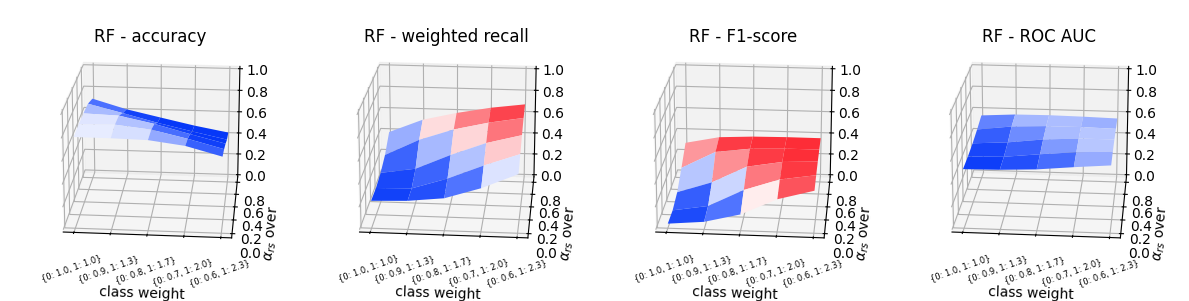

In [66]:
fig_ex1_rf = generate_3d_plots(
  'CLASS_WEIGHT', 
  'RF', 
  grid_search=loaded_experiments['grid_search_experiment_1_rf__'], 
  metrics=performance_metrics, 
  metric_ranges_map=metric_ranges_map,
  oversample_strategies_map=oversample_strategies_map, 
  experiment_ratio_to_name_map=class_weights_map,
  all_class_weights=all_class_weights
)
fig_ex1_rf.canvas.draw()
fig_ex1_rf.tight_layout()

savefig_for_overleaf(dataset_folder_name, "fig_ex1_rf", fig_ex1_rf)

### lightgbm

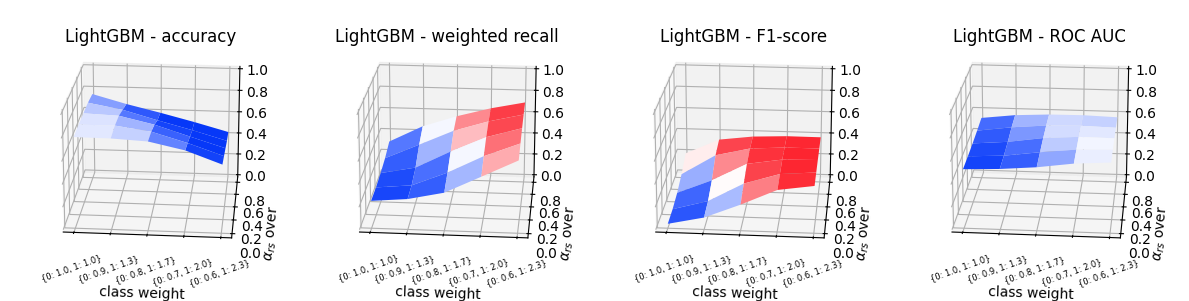

In [67]:
fig_ex1_lightgbm = generate_3d_plots(
  'CLASS_WEIGHT', 
  'LightGBM', 
  grid_search=loaded_experiments['grid_search_experiment_1_lightgbm__'], 
  metrics=performance_metrics,
  metric_ranges_map=metric_ranges_map,
  oversample_strategies_map=oversample_strategies_map, 
  experiment_ratio_to_name_map=class_weights_map,
  all_class_weights=all_class_weights
)
fig_ex1_lightgbm.canvas.draw()
fig_ex1_lightgbm.tight_layout()
savefig_for_overleaf(dataset_folder_name, "fig_ex1_lightgbm", fig_ex1_lightgbm)

In [ ]:
# fig = generate_statistical_diff_heatmap(experiment_name = 'CLASS_WEIGHT', model_name='LightGBM', grid_search=grid_search_experiment_1_lightgbm, metrics=performance_metrics)

### catboost

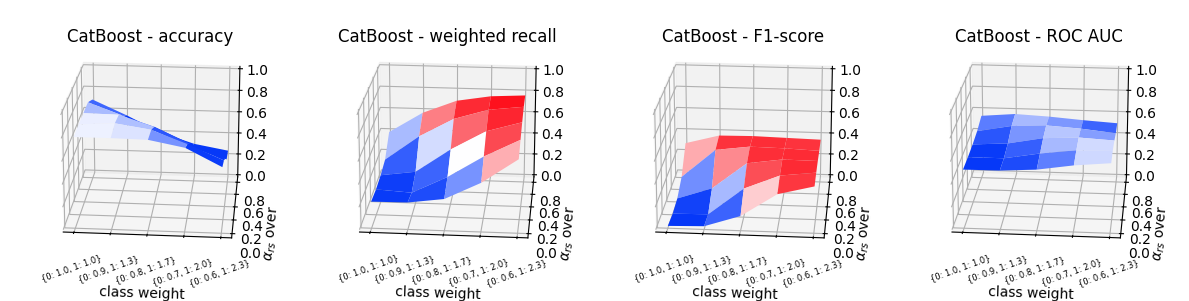

In [68]:
fig_ex1_catboost = generate_3d_plots(
  'CLASS_WEIGHT', 
  'CatBoost', 
  grid_search=loaded_experiments['grid_search_experiment_1_catboost__'], 
  metrics=performance_metrics,
  metric_ranges_map=metric_ranges_map,
  oversample_strategies_map=oversample_strategies_map, 
  experiment_ratio_to_name_map=class_weights_map,
  all_class_weights=all_class_weights
)
fig_ex1_catboost.canvas.draw()
fig_ex1_catboost.tight_layout()
savefig_for_overleaf(dataset_folder_name, "fig_ex1_catboost", fig_ex1_catboost)

In [ ]:
# fig = generate_statistical_diff_heatmap(experiment_name = 'CLASS_WEIGHT', model_name='CatBoost', grid_search=grid_search_experiment_1_catboost, metrics=performance_metrics)

### between-model comparison
The results of the best_estimator_ of each algorithm will be compared between each other to see if there is any difference in performance.

## Experiment 2

### in-model comparison
The three algorithms used to train the models will be evaluated under applying different levels of oversampling and random undersampling.

In [69]:
undersampling_ratios_map = {
  under_ratio_50: round(under_ratio_50, 2),
  under_ratio_low: round(under_ratio_low, 2),
  under_ratio_middle: round(under_ratio_middle, 2),
  under_ratio_high: round(under_ratio_high, 2),
  under_ratio_balanced: round(under_ratio_balanced, 2)
}

### rf

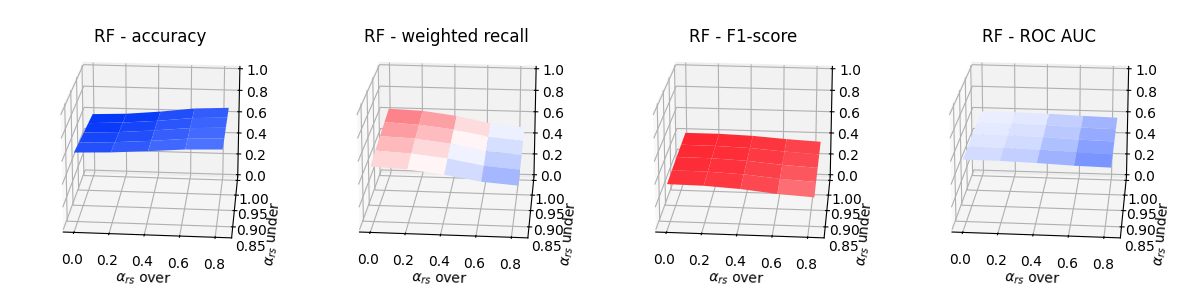

In [72]:
fig_ex2_rf = generate_3d_plots(
  'UNDERSAMPLE', 'RF', 
  grid_search=loaded_experiments['grid_search_experiment_2_rf__'], 
  metrics=performance_metrics,
  metric_ranges_map=metric_ranges_map,
  oversample_strategies_map=oversample_strategies_map, 
  experiment_ratio_to_name_map=undersampling_ratios_map,
  all_class_weights=None
)
fig_ex2_rf.canvas.draw()
fig_ex2_rf.tight_layout()
savefig_for_overleaf(dataset_folder_name, "fig_ex2_rf", fig_ex2_rf)

### lightgbm

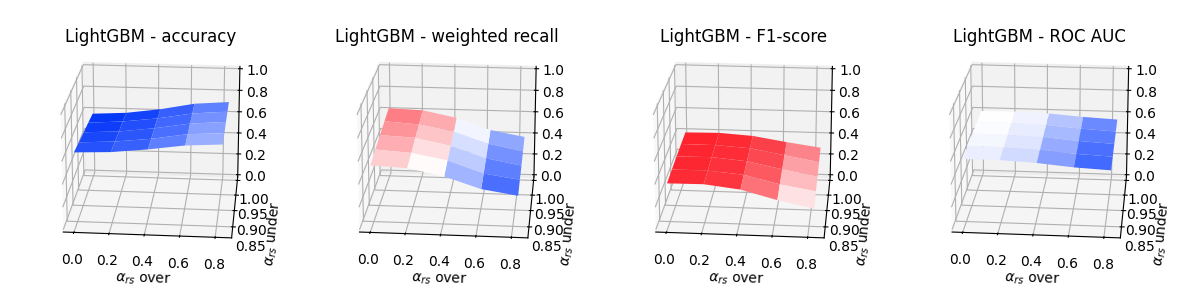

In [73]:
fig_ex2_lightgbm = generate_3d_plots(
  'UNDERSAMPLE', 
  'LightGBM', 
  grid_search=loaded_experiments['grid_search_experiment_2_lightgbm__'], 
  metrics=performance_metrics,
  metric_ranges_map=metric_ranges_map,
  oversample_strategies_map=oversample_strategies_map, 
  experiment_ratio_to_name_map=undersampling_ratios_map,
  all_class_weights=None
)
fig_ex2_lightgbm.canvas.draw()
fig_ex2_lightgbm.tight_layout()
savefig_for_overleaf(dataset_folder_name, "fig_ex2_lightgbm", fig_ex2_lightgbm)

### catboost

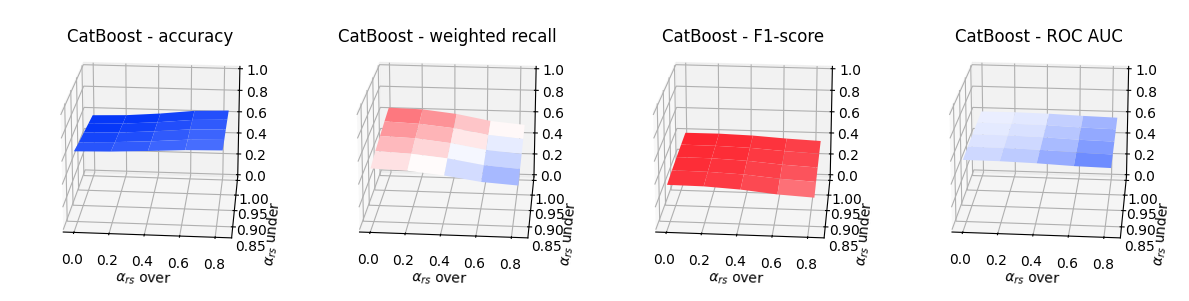

In [74]:
fig_ex2_catboost = generate_3d_plots(
  'UNDERSAMPLE', 
  'CatBoost', 
  grid_search=loaded_experiments['grid_search_experiment_2_catboost__'], 
  metrics=performance_metrics,
  metric_ranges_map=metric_ranges_map,
  oversample_strategies_map=oversample_strategies_map, 
  experiment_ratio_to_name_map=undersampling_ratios_map,
  all_class_weights=None
)
fig_ex2_catboost.canvas.draw()
fig_ex2_catboost.tight_layout()
savefig_for_overleaf(dataset_folder_name, "fig_ex2_catboost", fig_ex2_catboost)

## Experiment 3
The last experiment tries to mitigate any bias present by applying a data preprocessing called DisparateImpactRemover to the dataset. In the experiment the repair-level is varied between [0, 0.33, 0.66, 1]. The impact not only on the fairness metrics will be measured, but also on the performance metrics of the model

### in model comparison

In [ ]:
# param_grid_ex3 = createParamGridEx3(grid_searches)

#should be smae order as grid_searches
experiment_and_model_name = {
  'experiment_1_rf',
  'experiment_2_rf',
  'experiment_1_lightgbm',
  'experiment_2_lightgbm',
  'experiment_1_catboost',
  'experiment_2_catboost'
}

if len(grid_searches) != len(experiment_and_model_name):
  print("please adjust the experiment")

# experiment_and_model_to_params_map = {}
# for i in range(len(experiment_and_model_name)):
#   experiment_and_model_to_params_map[experiment_and_model_name[i]] = grid_searches[i]

In [ ]:
# #for this purpose the classifier is considered equal if the same ML algorithm is used
# def isSameClassifier(single_param_combination_1, single_param_combination):
#   if single_param_combination_1['classifier'].__class__.__name__ == single_param_combination_1['classifier'].__class__.__name__:
#     return True
#   return False

In [ ]:
lister = [1,2,3]
list(map(lambda x: x - lister[0], lister))

In [ ]:
def generateGraphData(grid_searches_experiment_3, repair_levels, metrics, i):
  graph_data = {'repair_levels':repair_levels}
  # print(len(repair_levels))
  for metric in metrics:
    col = []
    for grid_search in grid_searches_experiment_3:
      results = grid_search.cv_results_
      col.append(results['mean_test_' + metric][i])
    diff = list(map(lambda x: x - col[0], col))
    graph_data[metric] = diff
    # print(len(col))
  return graph_data   

def generateRepairLevelPlots(dfs, axes, ylim=None):
  if len(dfs) != len(axes):
    raise Exception("Unequal length axes and dfs ", dfs, axes)
  last_ax = None
  for i in range(len(dfs)):
    melted = pd.melt(dfs[i], 'repair_levels', var_name='scorer', value_name=r'$\Delta$ metric score')
    ax = sns.lineplot(data=melted, x='repair_levels', y=r'$\Delta$ metric score', hue='scorer', ax=axes[i])
    ax.legend().set_visible(False)
    ax.set_ylabel(None)
    ax.set_ylim(*ylim)
    if i == len(dfs)-1:
      last_ax = ax
  return last_ax


In [ ]:
def getMLAlgorithmName(param):
  alg = param['classifier']
  name = alg.__class__.__name__
  alg_name = None
  if name == 'RandomForestClassifier':
    alg_name = 'RF'
  elif name == 'LGBMClassifier':
    alg_name = 'LightGBM'
  elif name == 'CatBoostClassifier':
    alg_name = 'CatBoost'
  else:
    raise Exception("unknown classifier")
  return alg_name

In [ ]:
def compare_param_grid(experiment_name, grid_searches_experiment_3, repair_levels, performance_metrics, fairness_metrics):
  #ex1 fairness and performance
  dfs_protected_fairness = []
  dfs_unprotected_fairness = []
  dfs_performance = []
  titles = []
  #experiment 1
  loop_range = []
  if experiment_name == 'CLASS_WEIGHT':
    loop_range = range(0, len(grid_searches_experiment_3[0].cv_results_['params']), 2)
  elif experiment_name == 'UNDERSAMPLE':
    loop_range = range(1, len(grid_searches_experiment_3[0].cv_results_['params']), 2)
  #each gridsearch is 1 repair level
  #looping through the params responsible for all the results for experiment 1
  for i in loop_range:
    #QUICK SOLUTION
    #fairness_metrics = ['spd_gender', 'eod_gender', 'spd_education', 'eod_education', 'spd_region', 'eod_region']
    protected_fairness_data = generateGraphData(grid_searches_experiment_3, repair_levels, ['spd_gender', 'eod_gender'], i=i)
    df_protected_fairness_metrics = pd.DataFrame(protected_fairness_data)
    dfs_protected_fairness.append(df_protected_fairness_metrics)
    
    unprotected_fairness_data = generateGraphData(grid_searches_experiment_3, repair_levels, ['spd_education', 'eod_education', 'spd_region', 'eod_region'], i=i)
    df_unprotected_fairness_metrics = pd.DataFrame(unprotected_fairness_data)
    dfs_unprotected_fairness.append(df_unprotected_fairness_metrics)
    
    performance_data = generateGraphData(grid_searches_experiment_3, repair_levels, performance_metrics, i=i)
    df_performance_metrics = pd.DataFrame(performance_data)
    dfs_performance.append(df_performance_metrics)
    
    #save name for title
    param = grid_searches_experiment_3[0].cv_results_['params'][i]
    alg_name = getMLAlgorithmName(param)
    titles.append(alg_name)
  
  figsize = (10, 8)
  fig, axes = plt.subplots(nrows=3, ncols=3, figsize=figsize)
  last_ax_row1 = generateRepairLevelPlots(dfs_protected_fairness, axes[0], ylim=[-0.1, 0.1])
  last_ax_row2 = generateRepairLevelPlots(dfs_unprotected_fairness, axes[1], ylim=[-0.1, 0.1])
  last_ax_row3 = generateRepairLevelPlots(dfs_performance, axes[2], ylim=[-0.1, 0.1])
  
  #adjust for legend room
  # fig.subplots_adjust(right=0.8)
  last_ax_row1.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left', 
    borderaxespad=0.,
    fontsize=10
  );
  
  last_ax_row2.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left', 
    borderaxespad=0.,
    fontsize=10
  );
  
  last_ax_row3.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left', 
    borderaxespad=0.,
    fontsize=10
  );
  
  for ax, titles in zip(axes[0], titles):
    ax.set_title(titles)
    
  rows = ['protected bias feature', 'unprotected bias features', 'performance trade-off']
  for ax, row in zip(axes[:, 0], rows):
    ax.set_ylabel(row + '\n' + r'$\Delta$ metric score')
  
  fig.suptitle("Results for experiment " + experiment_name.lower().replace("_", " "))
  fig.tight_layout()
  return fig

In [378]:
grid_searches_experiment_3[0].cv_results_['mean_test_f_score']

array([0.25830898, 0.27279173, 0.292709  , 0.29084287, 0.28413084,
       0.27564277])

In [182]:
grid_searches_experiment_3[0].cv_results_['mean_test_spd_gender']

array([-0.03954224, -0.04914555, -0.11726642, -0.11537756, -0.09783279,
       -0.05003333])

In [234]:
grid_searches_experiment_3[4].cv_results_['mean_test_f_score']

array([0.25528462, 0.26144029, 0.26903877, 0.2681497 , 0.26686274,
       0.26314141])

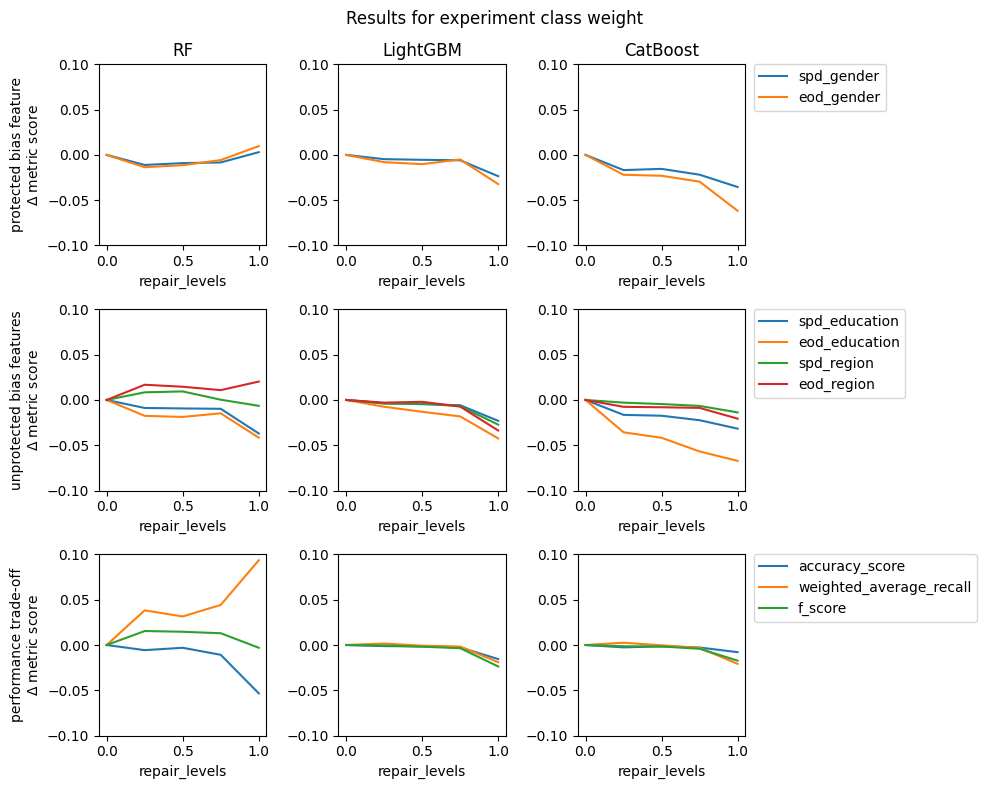

In [402]:
fig = compare_param_grid('CLASS_WEIGHT', grid_searches_experiment_3, repair_levels, performance_metrics, fairness_metrics)
savefig_for_overleaf('experiment_3_class_weight', fig)

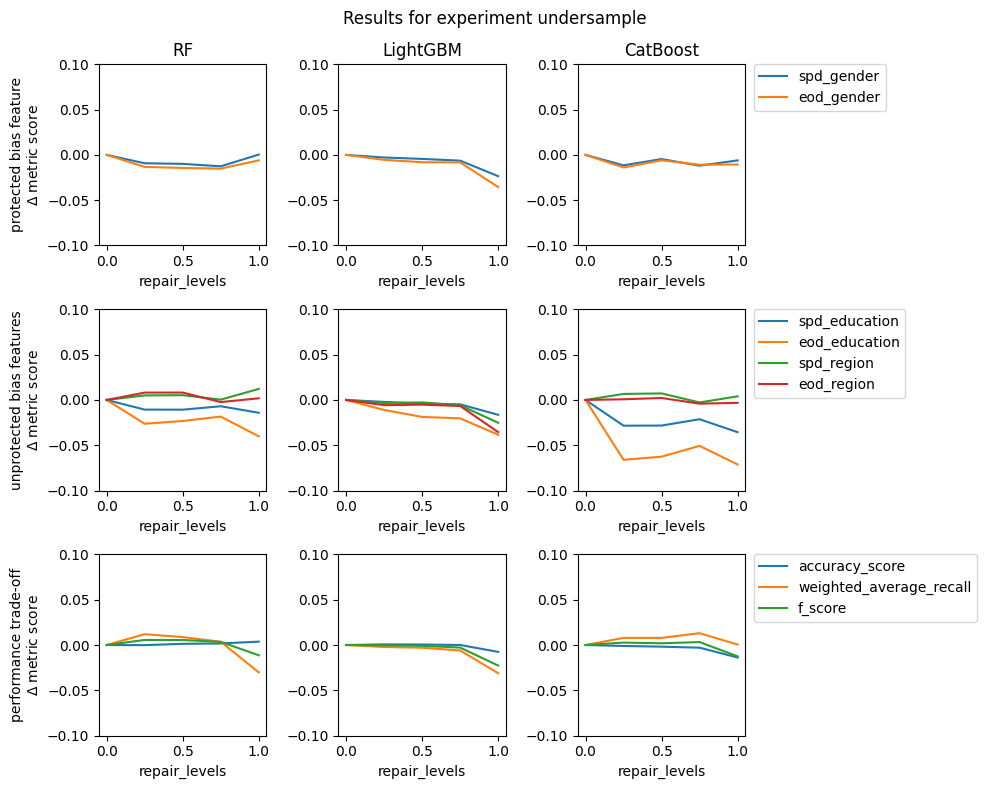

In [403]:
fig = compare_param_grid('UNDERSAMPLE', grid_searches_experiment_3, repair_levels, performance_metrics, fairness_metrics)
savefig_for_overleaf('experiment_3_undersample', fig)

### rf

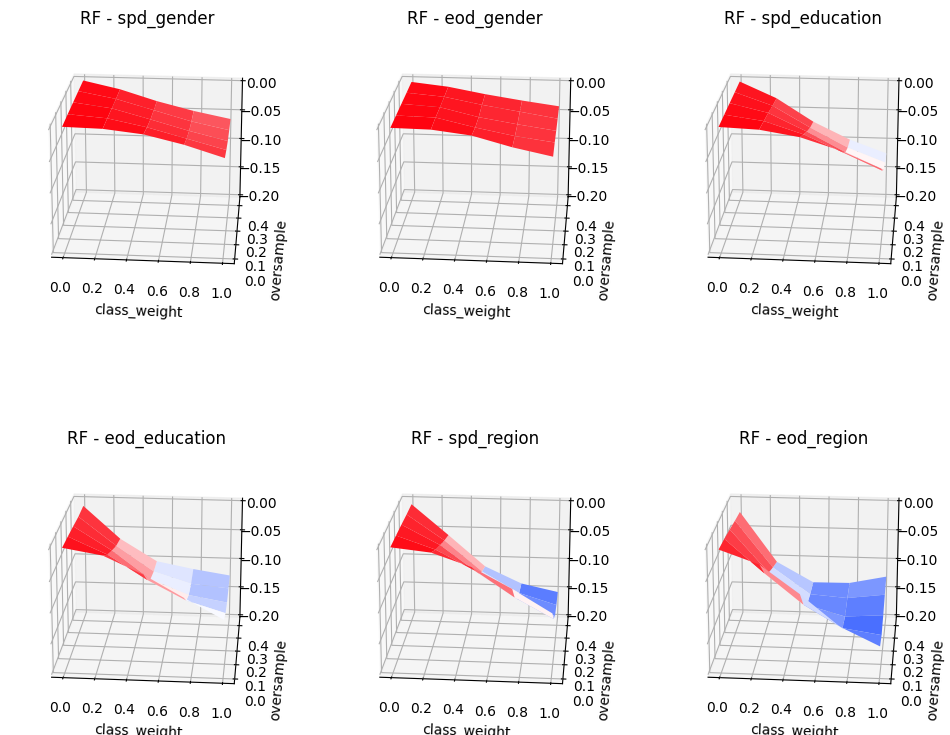

In [551]:
fig = generate_3d_plots_BIAS('CLASS_WEIGHT', 'RF', grid_search=grid_search_experiment_1_rf, metrics=fairness_metrics, zlim=[-0.2, 0])

unfamiliar metric, metricRead is set to metric
unfamiliar metric, metricRead is set to metric
unfamiliar metric, metricRead is set to metric
unfamiliar metric, metricRead is set to metric
unfamiliar metric, metricRead is set to metric
unfamiliar metric, metricRead is set to metric


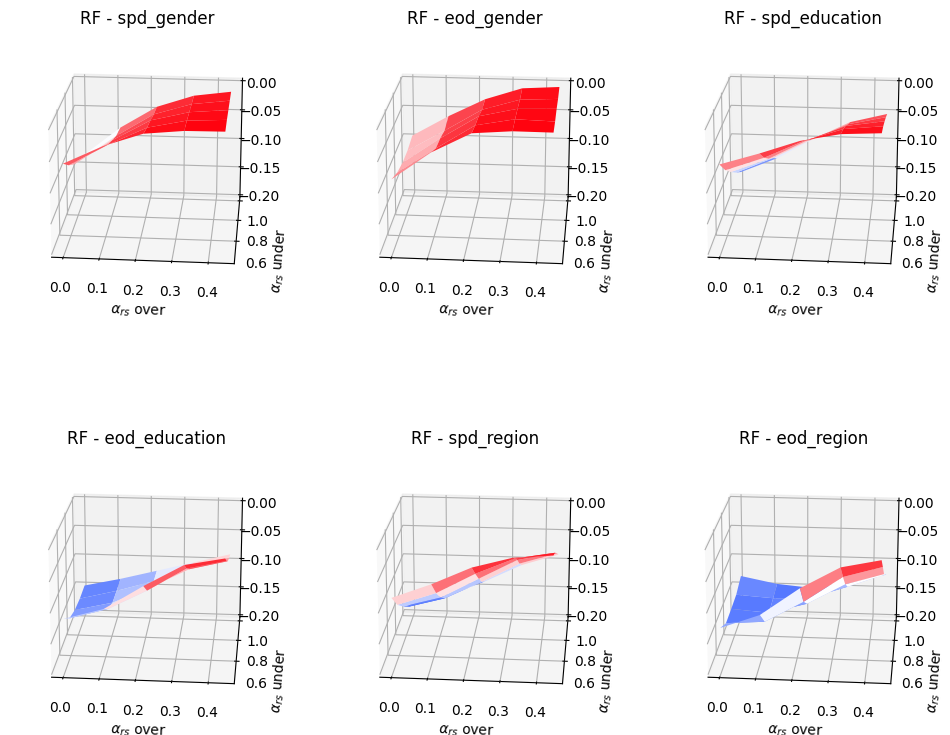

In [104]:
fig = generate_3d_plots_BIAS('UNDERSAMPLE', 'RF', grid_search=grid_search_experiment_2_catboost, metrics=fairness_metrics, zlim=[-0.2, 0])

### lightgbm

unfamiliar metric, metricRead is set to metric
unfamiliar metric, metricRead is set to metric
unfamiliar metric, metricRead is set to metric
unfamiliar metric, metricRead is set to metric
unfamiliar metric, metricRead is set to metric
unfamiliar metric, metricRead is set to metric


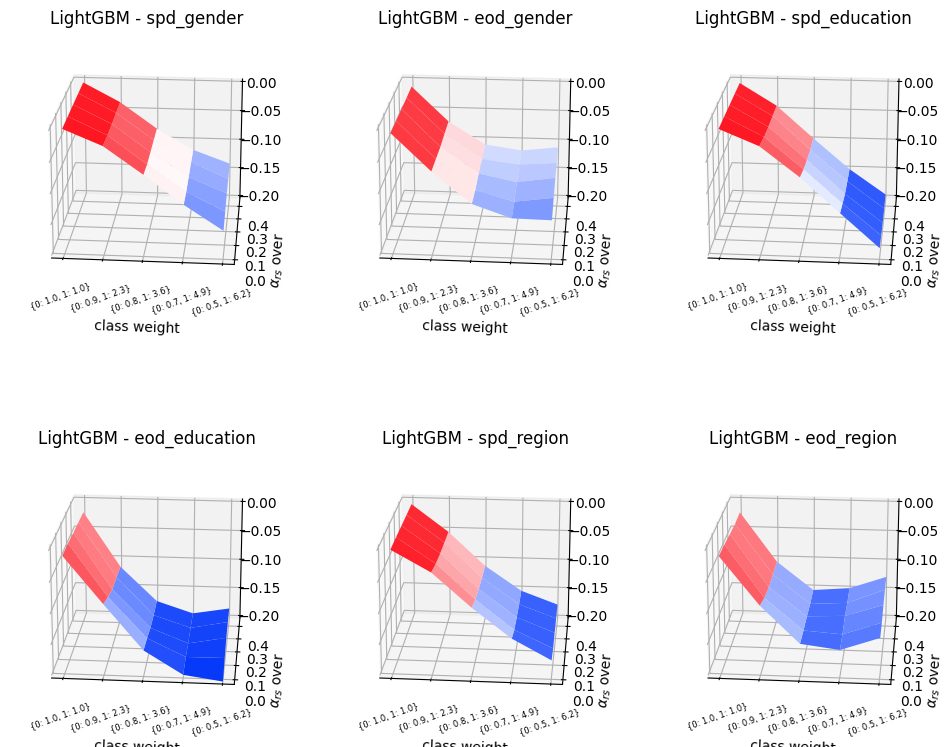

In [104]:
fig = generate_3d_plots_BIAS('CLASS_WEIGHT', 'LightGBM', grid_search=grid_search_experiment_1_lightgbm, metrics=fairness_metrics, zlim=[-0.2, 0])

unfamiliar metric, metricRead is set to metric
unfamiliar metric, metricRead is set to metric
unfamiliar metric, metricRead is set to metric
unfamiliar metric, metricRead is set to metric
unfamiliar metric, metricRead is set to metric
unfamiliar metric, metricRead is set to metric


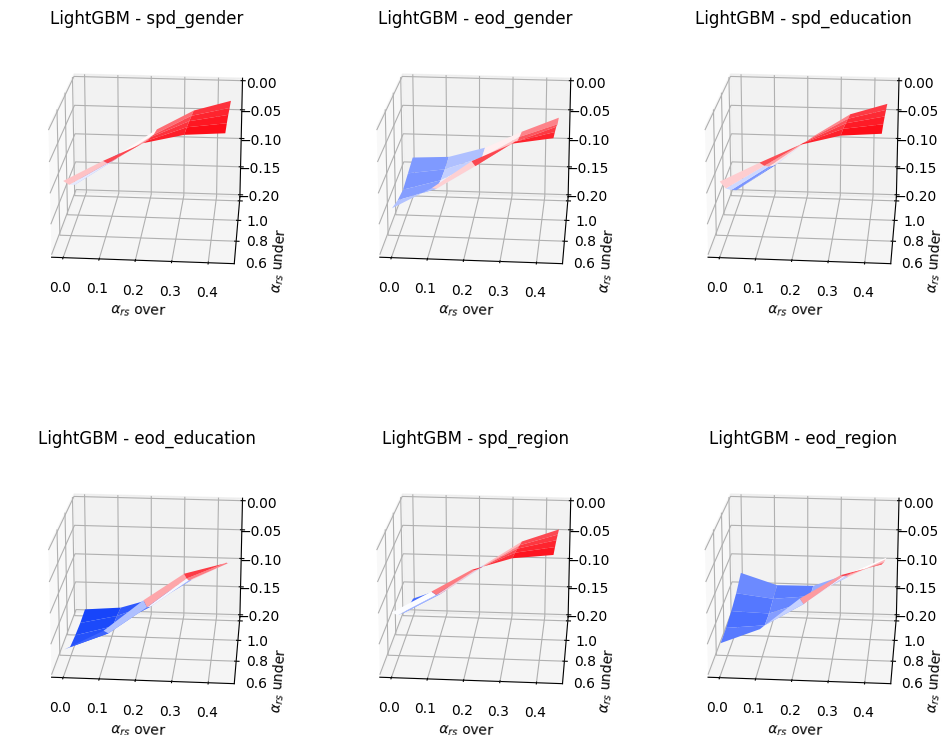

In [105]:
fig = generate_3d_plots_BIAS('UNDERSAMPLE', 'LightGBM', grid_search=grid_search_experiment_2_lightgbm, metrics=fairness_metrics, zlim=[-0.2, 0])

### catboost

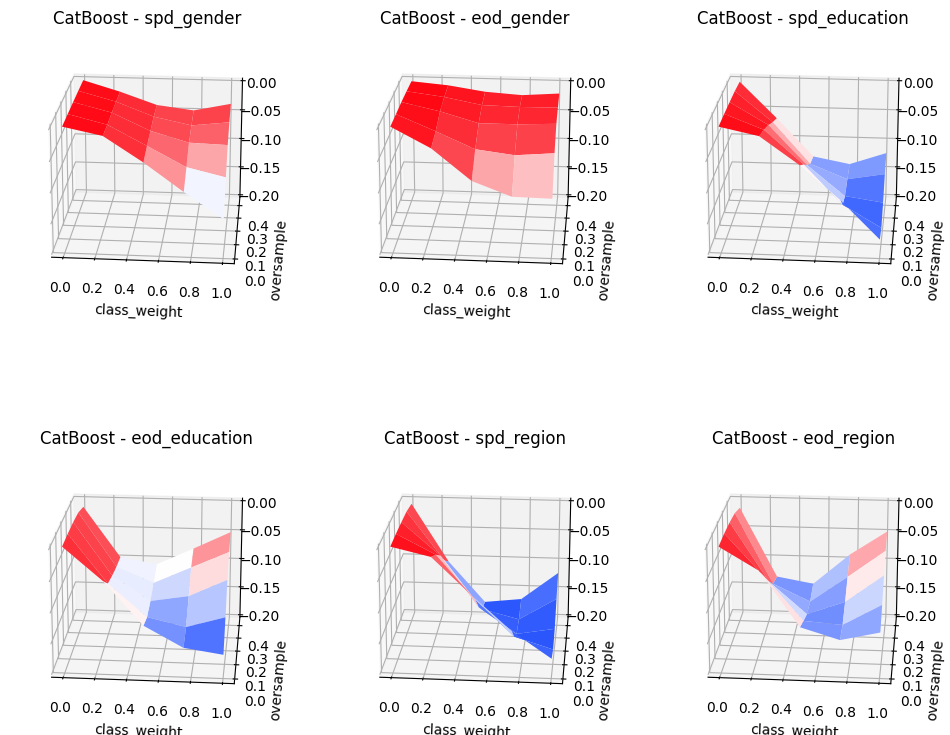

In [553]:
fig = generate_3d_plots_BIAS('CLASS_WEIGHT', 'CatBoost', grid_search=grid_search_experiment_1_catboost, metrics=fairness_metrics, zlim=[-0.2, 0])

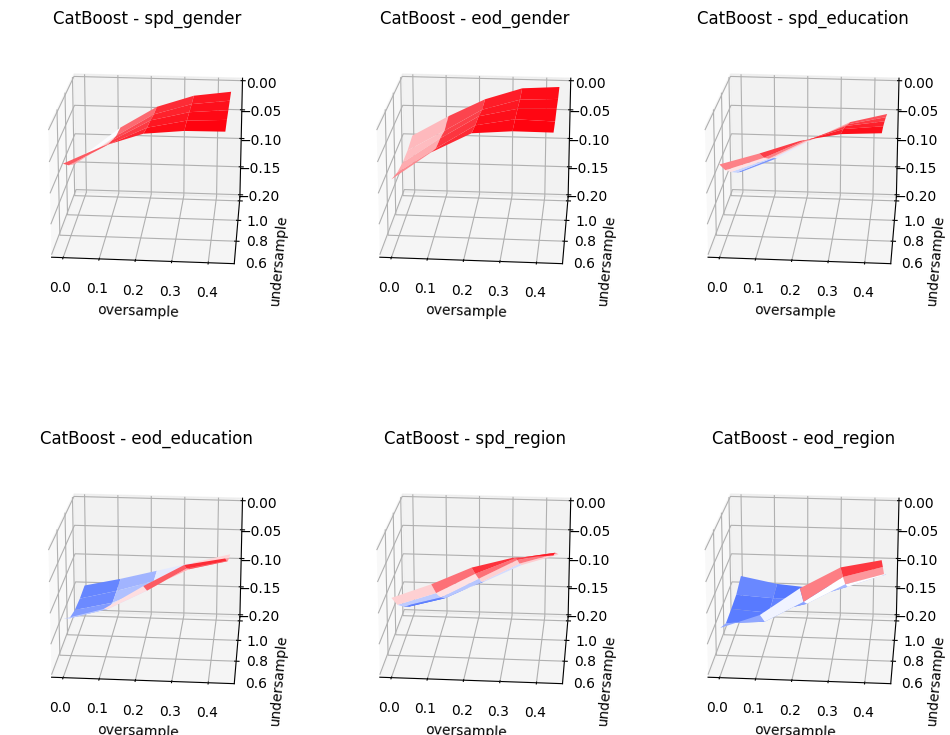

In [555]:
fig = generate_3d_plots_BIAS('UNDERSAMPLE', 'CatBoost', grid_search=grid_search_experiment_2_catboost, metrics=fairness_metrics, zlim=[-0.2, 0])

### between model comparison

## Feature Importance Plot

In [491]:
def getFinalColnames(grid_search):
  pipeline = grid_search.best_estimator_
  if len(pipeline.steps) != 5:
    raise Exception("please change this function to reflect the changes")
  #prepocessing pipeline_steps
  # data_cleaning_and_preparation = grid_search.best_estimator_.steps[0][1]
  # oversample = grid_search.best_estimator_.steps[1][1]
  # undersample = grid_search.best_estimator_.steps[2][1]
  # cat_encoding_and_feature_engineering = grid_search.best_estimator_.steps[3][1]
  # [data_cleaning_and_preparation, oversample, undersample, cat_encoding_and_feuture_engineering
  prev_features_names_out = None
  for i in range(len(pipeline.steps)-1):
    step = pipeline.steps[i][1]
    if i == 0:
      prev_features_names_out = step.get_feature_names_out()
    elif step == 'passthrough':
      continue
    else:
      prev_features_names_out = step.get_feature_names_out(input_features=prev_features_names_out)
  #last step is classifier
  return prev_features_names_out

In [458]:
def plot_feature_importances(feature_names, importances, amount_of_features):
  #src: https://www.kaggle.com/code/ashishpatel26/feature-importance-of-lightgbm
  features_importances_dict = list(zip(feature_names, importances))
  feature_imp = pd.DataFrame(sorted(features_importances_dict), columns=['Feature', 'Importance'])
  data = feature_imp.sort_values(by="Importance", ascending=False).head(amount_of_features)
  fig = plt.figure(figsize=(20, 10))
  ax = sns.barplot(x="Importance", y="Feature", data=data)
  ax.set_xlabel("Feature importance")
  ax.set_ylabel("Features")
  return ax

### rf

<Axes: xlabel='Feature importance', ylabel='Features'>

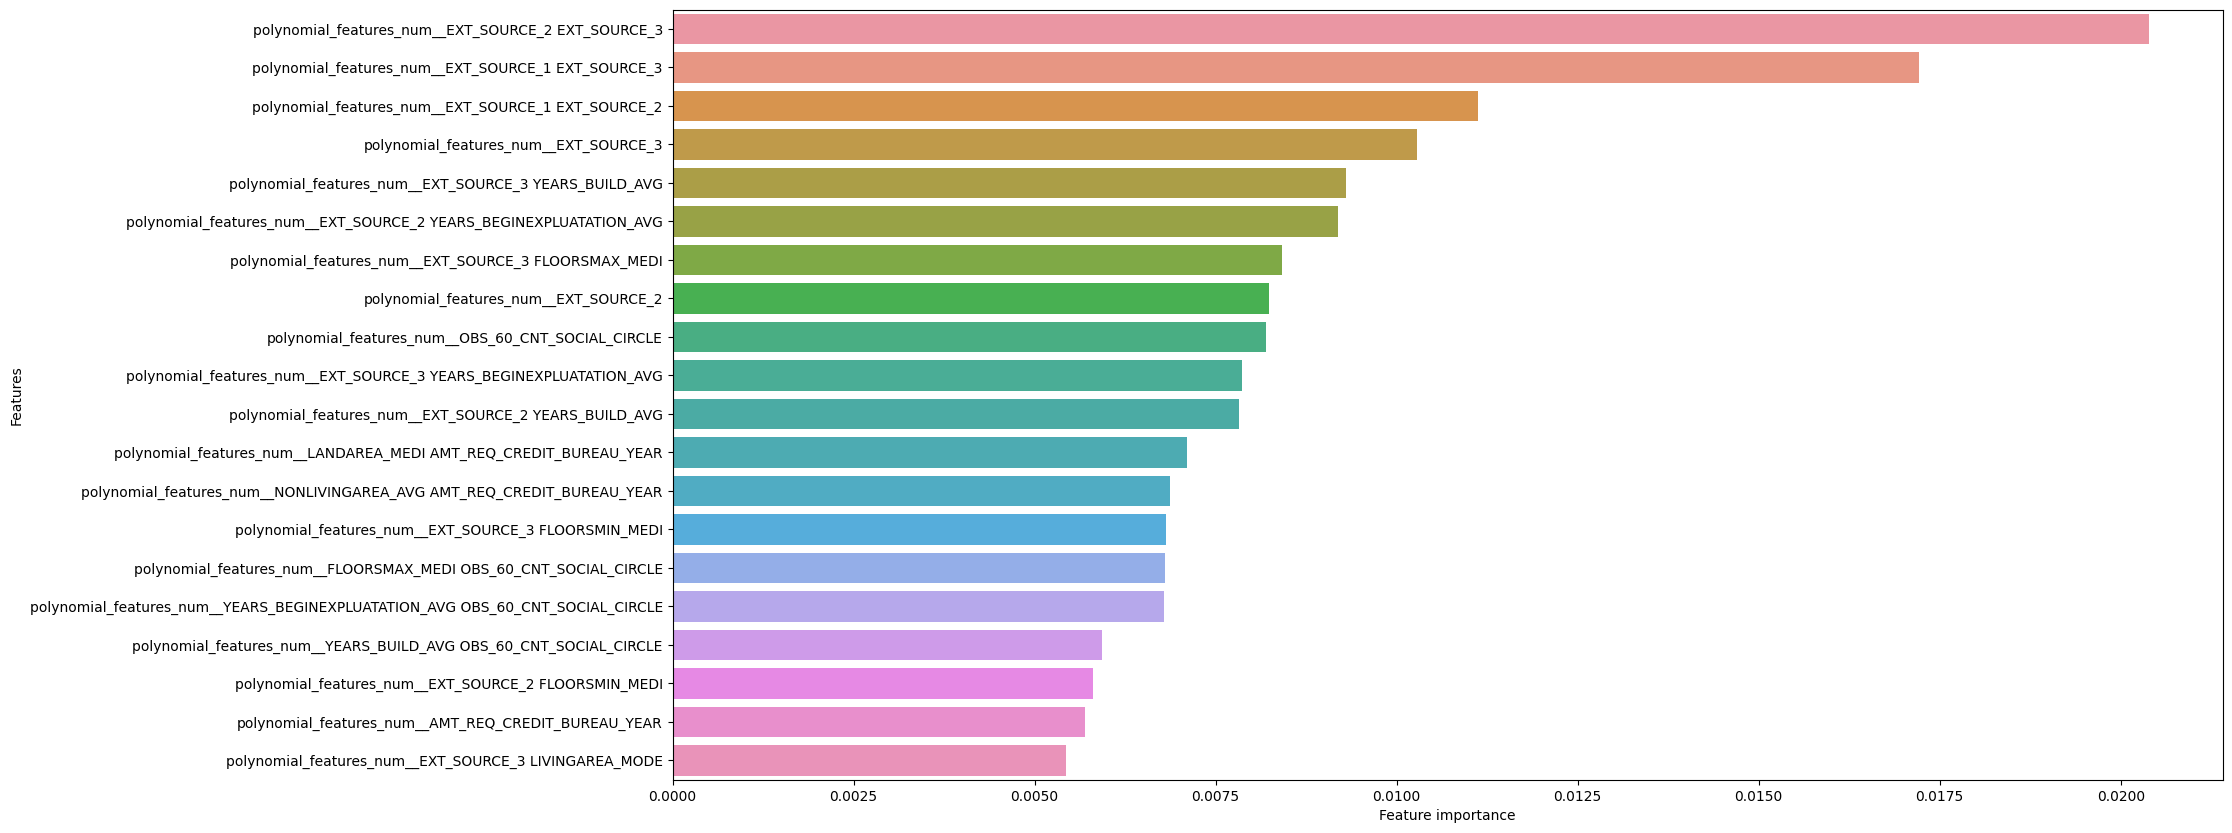

In [494]:
fitted_rf_clf = grid_search_experiment_1_rf.best_estimator_.named_steps['classifier']
importances_rf = fitted_rf_clf.feature_importances_
feature_names_rf = getFinalColnames(grid_search_experiment_1_rf)
plot_feature_importances(feature_names_rf, importances_rf, 20)

### lightgbm

<Axes: xlabel='Feature importance', ylabel='Features'>

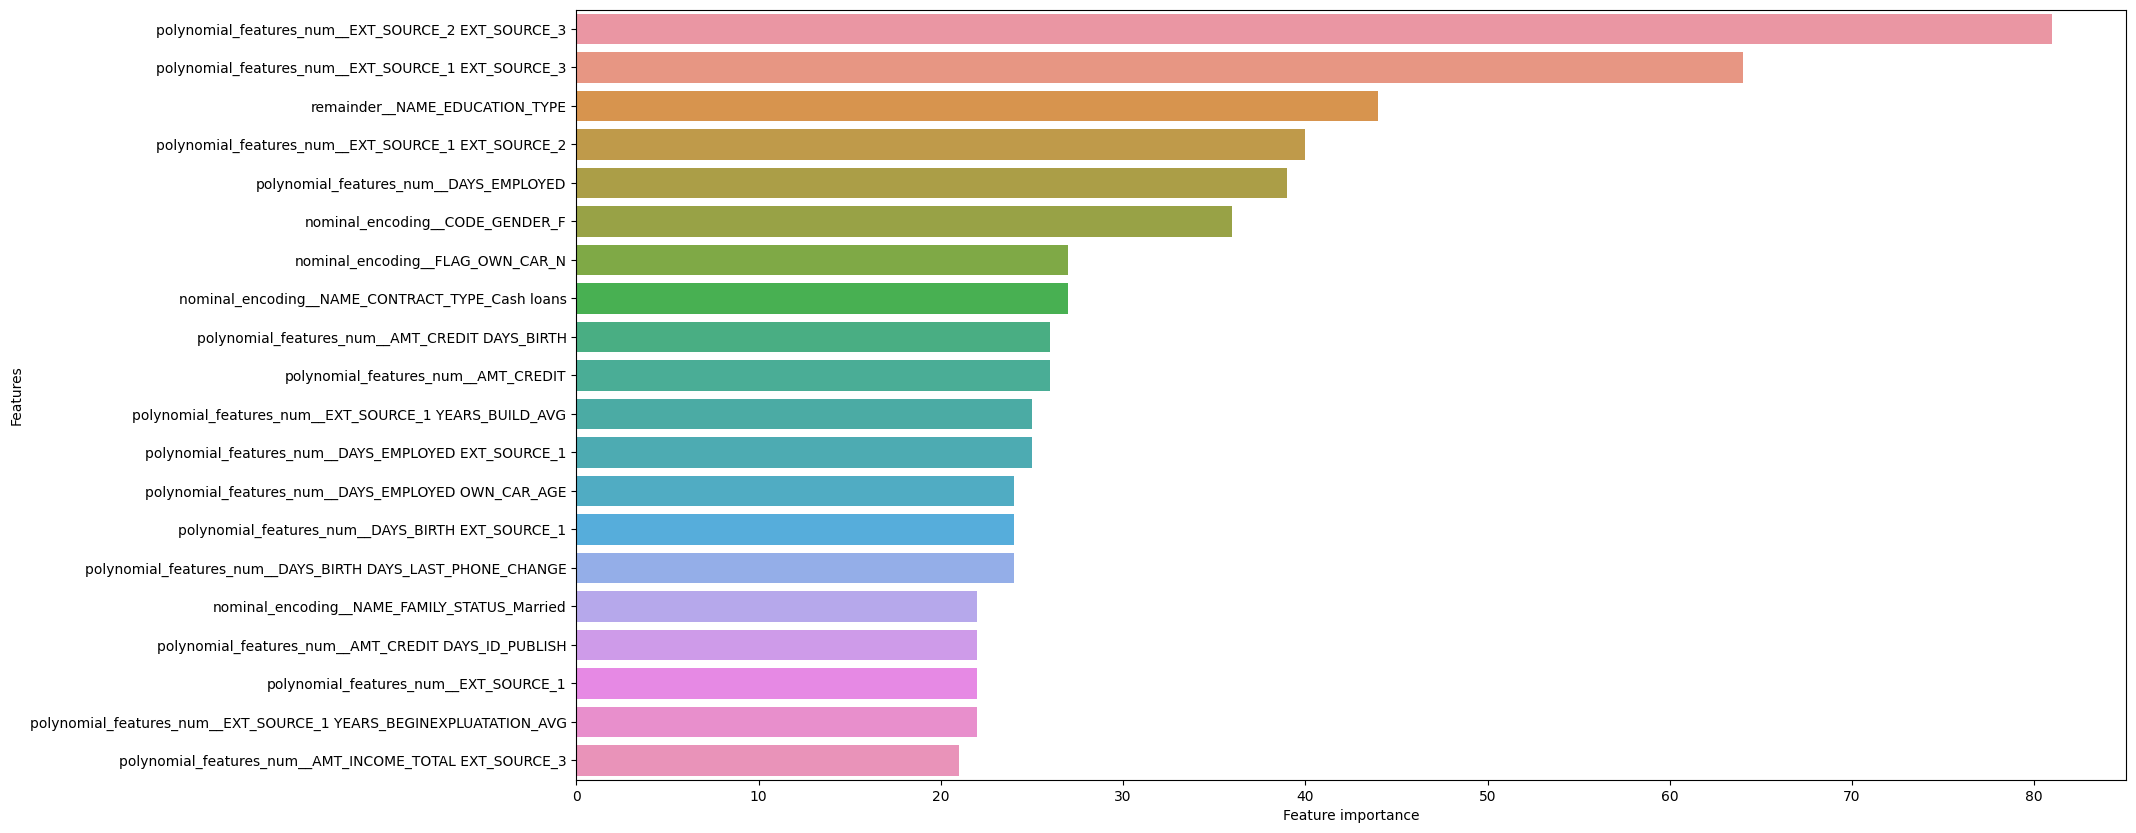

In [496]:
# importance_type (str, optional (default='split')) – The type of feature importance to 
# be filled into feature_importances_. If ‘split’, result contains numbers of times the 
# feature is used in a model. If ‘gain’, result contains total gains of splits which use the feature.

fitted_lightgbm_clf = grid_search_experiment_1_lightgbm.best_estimator_.named_steps['classifier']
# print(fitted_lightgbm_clf._Booster.dump_model()['feature_names'])
#plot_feature_importance(features_importances_dict_lightgbm)
importances_lightgbm = fitted_lightgbm_clf.feature_importances_
feature_names_lightgbm = getFinalColnames(grid_search_experiment_1_lightgbm)
plot_feature_importances(feature_names_lightgbm, importances_lightgbm, 20)

### catboost

<Axes: xlabel='Feature importance', ylabel='Features'>

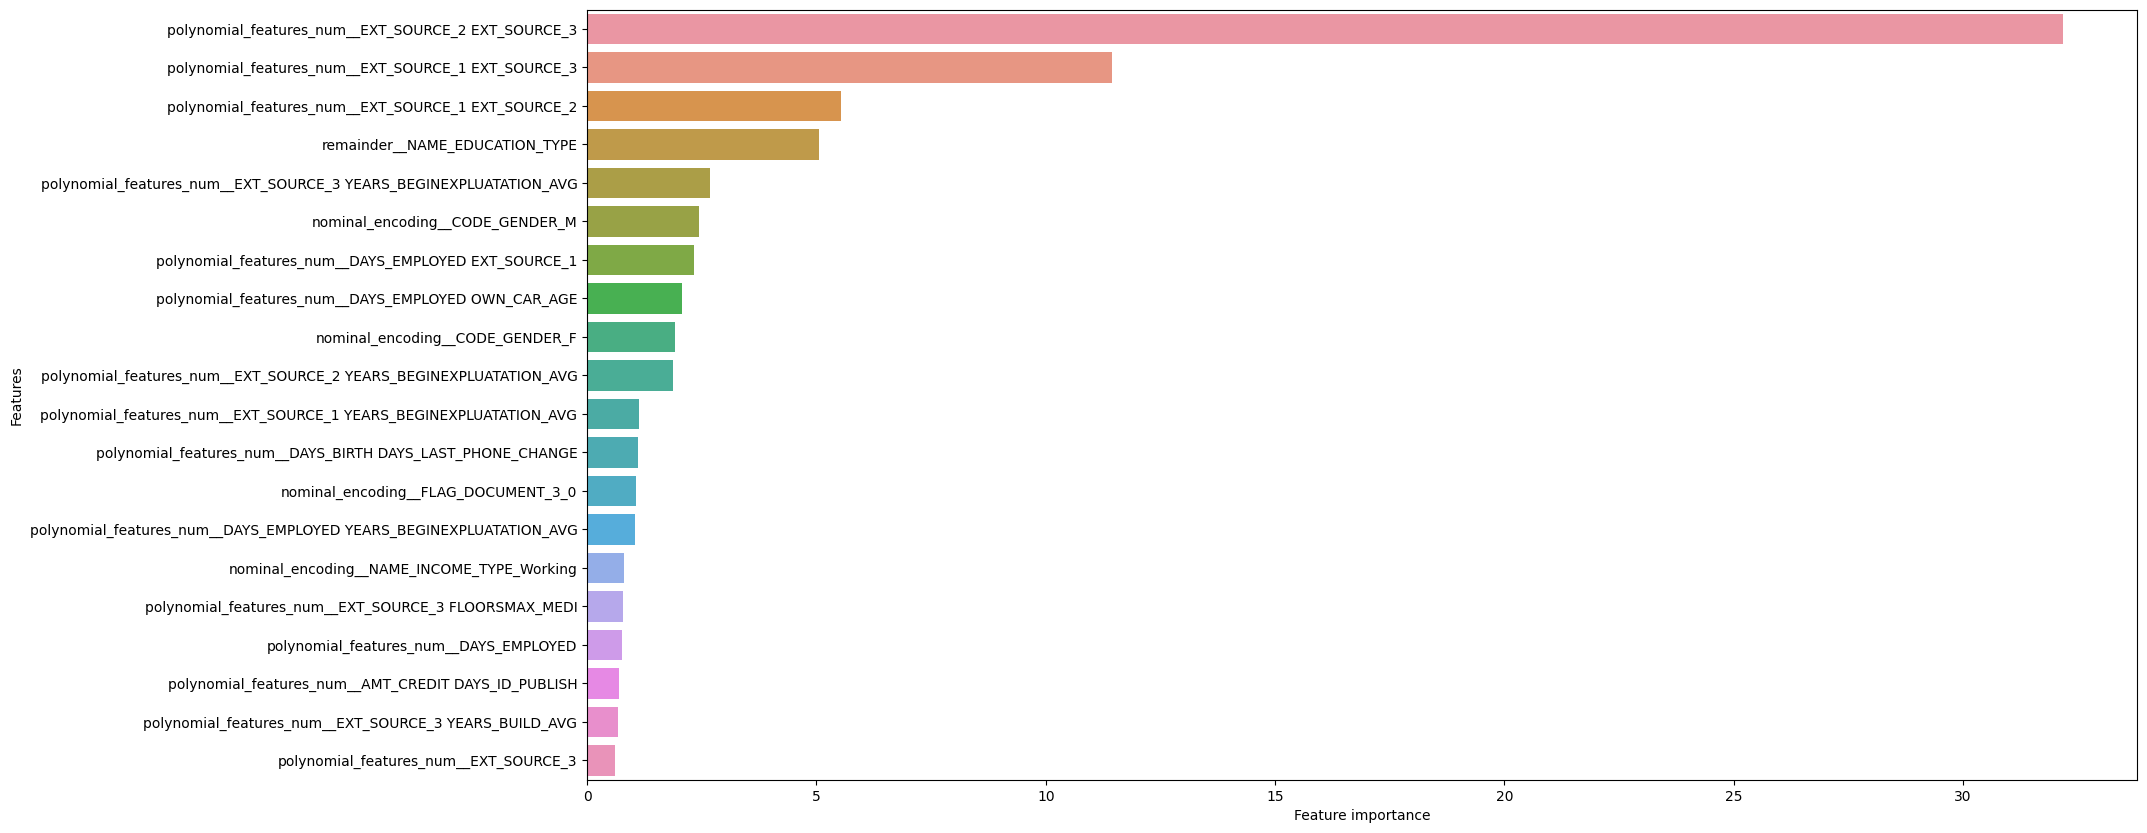

In [497]:
# for catboost
# https://catboost.ai/en/docs/features/feature-importances-calculation
#https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier_get_feature_importance
fitted_catboost_clf = grid_search_experiment_1_catboost.best_estimator_.named_steps['classifier']                                                                 
importances_catboost = fitted_catboost_clf.get_feature_importance()
feature_names_catboost = getFinalColnames(grid_search_experiment_1_catboost)
plot_feature_importances(feature_names_catboost, importances_catboost, 20)

# Bias evaluation

In [502]:
#the test for bias will be evaluated on the whole dataset
X_test = X
y_test = y

##Partial dependency plot

https://scikit-learn.org/stable/modules/partial_dependence.html#partial-dependence
https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html

In [509]:
from sklearn.inspection import (partial_dependence, PartialDependenceDisplay)
def get_all_partial_dependence_plots(experiment_name, bias_sensitive_cols, grid_search_rf, grid_search_lightgbm, grid_search_catboost):
  included_cols = bias_sensitive_cols
  n_cols = 2
  n_rows = int(math.ceil(len(included_cols)/n_cols))
  #src: https://towardsdatascience.com/partial-dependence-plots-with-scikit-learn-966ace4864fc
  summary = {}

  fig, ax = plt.subplots(n_rows, n_cols, figsize=(10,12), sharey=True)
  for i, x in enumerate(included_cols):
    print("plotting...")
    # make dataframe
    # summary[x] = pd.DataFrame(columns=values)
    raw_values = partial_dependence(grid_search_rf.best_estimator_, X_test, x, kind='average')
    print("partial dependency plot for rf created")
    summary[x] = pd.DataFrame(columns=raw_values['values'][0])
    # load in partial_dependency_per_model
    summary[x].loc['rf'] = raw_values['average'][0]
    summary[x].loc['lightgbm'] = partial_dependence(
        grid_search_lightgbm.best_estimator_, X, x, kind='average'
    )['average'][0]
    print("partial dependency plot for lightgbm created")
    summary[x].loc['catboost'] = partial_dependence(
        grid_search_catboost.best_estimator_, X_test, x, kind='average'
    )['average'][0]
    print("partial dependency plot for catboost created")
    data = summary[x].reset_index().melt('index')
    loc = i//n_cols, i%n_cols
    if x=='CODE_GENDER' or x=='NAME_EDUCATION_TYPE':
      sns.barplot(data=data, x='variable', y='value', 
                     hue='index',ax=ax[loc]);
    elif i==1:
        sns.lineplot(data=data, x='variable', y='value', 
                     hue='index',ax=ax[loc]);
        ax[loc].legend(bbox_to_anchor=(1, 1));
        sns.scatterplot(data=data, x='variable', y='value', 
                    hue='index', ax=ax[loc], legend=False)
    else: 
        sns.lineplot(data=data, x='variable', y='value', 
                     hue='index', ax=ax[loc], legend=False);
        sns.scatterplot(data=data, x='variable', y='value', 
                    hue='index', ax=ax[loc], legend=False)
    if x=='NAME_EDUCATION_TYPE':
      ax[loc].set_xticklabels(ax[loc].get_xticklabels(), rotation=60)

    ax[loc].set_xlabel(x)
    if i%n_cols==0:
        ax[loc].set_ylabel('Partial dependence')
  fig.suptitle('Partial Dependence Plots')
  fig.tight_layout()
  return fig

plotting...
partial dependency plot for rf created
partial dependency plot for lightgbm created
partial dependency plot for catboost created
plotting...
partial dependency plot for rf created
partial dependency plot for lightgbm created
partial dependency plot for catboost created
plotting...
partial dependency plot for rf created
partial dependency plot for lightgbm created
partial dependency plot for catboost created


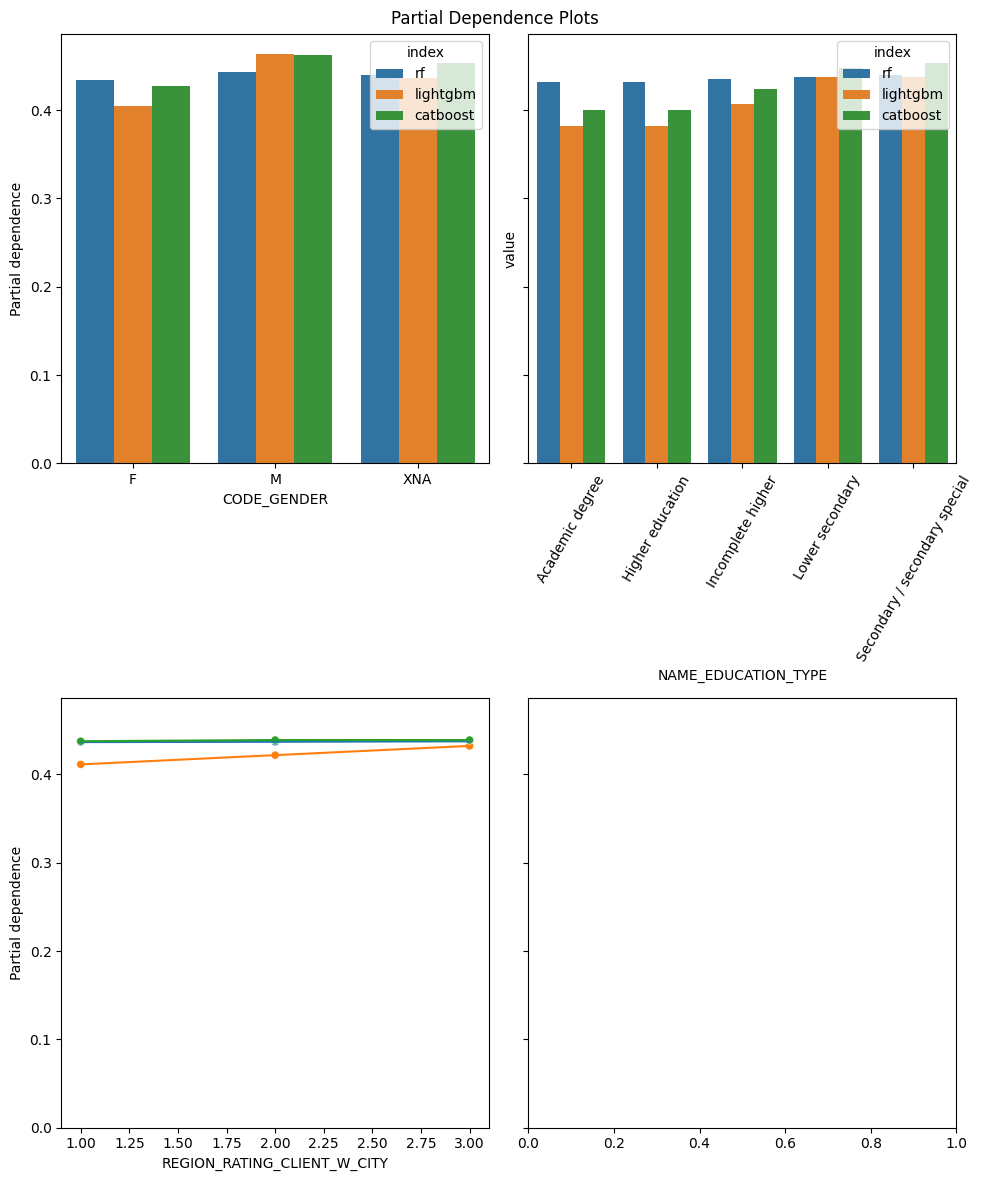

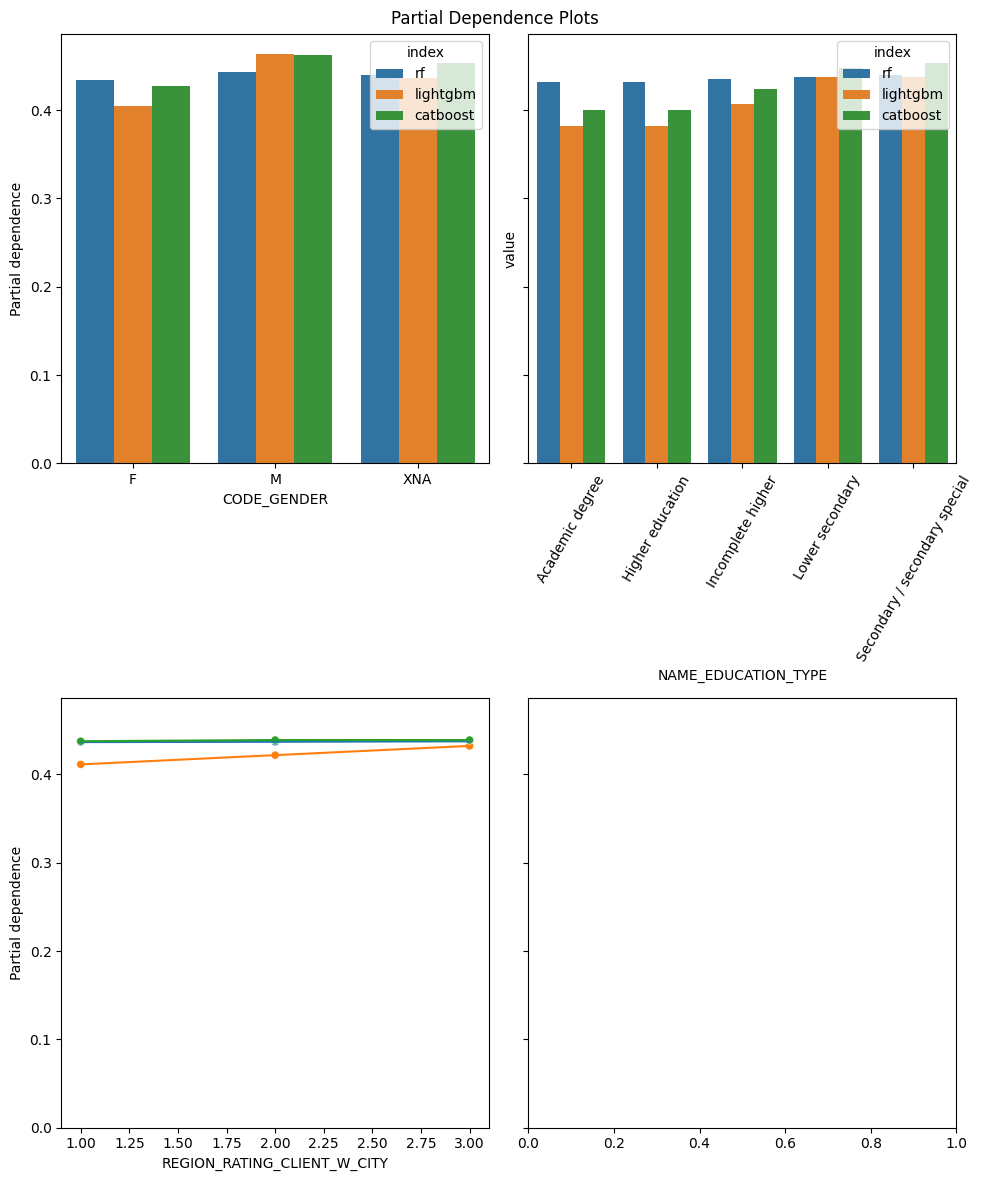

In [510]:
bias_sensitive_cols = ['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'REGION_RATING_CLIENT_W_CITY'] #'REGION_RATING_CLIENT' dropped due to correlation analysis
fig = get_all_partial_dependence_plots(experiment_name='UNDERSAMPLE', bias_sensitive_cols=bias_sensitive_cols, grid_search_rf=grid_search_experiment_2_rf, grid_search_lightgbm=grid_search_experiment_2_lightgbm, grid_search_catboost=grid_search_experiment_2_catboost)

plotting...
partial dependency plot for rf created
partial dependency plot for lightgbm created
partial dependency plot for catboost created
plotting...
partial dependency plot for rf created
partial dependency plot for lightgbm created
partial dependency plot for catboost created
plotting...
partial dependency plot for rf created
partial dependency plot for lightgbm created
partial dependency plot for catboost created


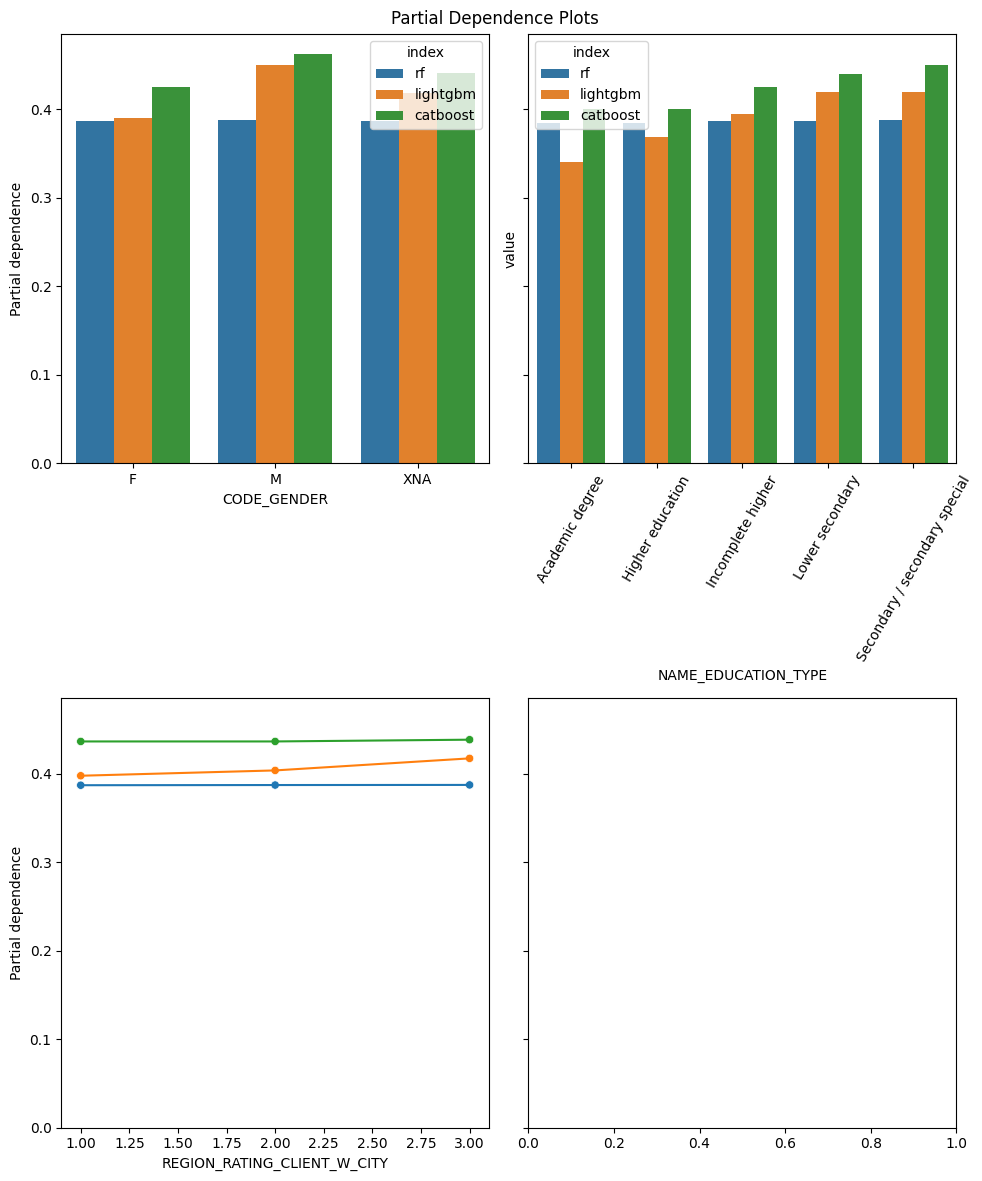

In [505]:
#https://towardsdatascience.com/how-to-tune-hyperparameters-of-machine-learning-models-a82589d48fc8
#look at this for how to build cool graphs
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
#this as well
from sklearn.inspection import (partial_dependence, PartialDependenceDisplay)
included_cols = ['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'REGION_RATING_CLIENT_W_CITY'] #'REGION_RATING_CLIENT' dropped due to correlation analysis
n_cols = 2
n_rows = int(math.ceil(len(included_cols)/n_cols))
#src: https://towardsdatascience.com/partial-dependence-plots-with-scikit-learn-966ace4864fc
summary = {}

fig, ax = plt.subplots(n_rows, n_cols, figsize=(10,12), sharey=True)
for i, x in enumerate(included_cols):
  print("plotting...")
  # make dataframe
  # summary[x] = pd.DataFrame(columns=values)
  raw_values = partial_dependence(grid_search_experiment_1_rf.best_estimator_, X_test, x, kind='average')
  print("partial dependency plot for rf created")
  summary[x] = pd.DataFrame(columns=raw_values['values'][0])
  # load in partial_dependency_per_model
  summary[x].loc['rf'] = raw_values['average'][0]
  summary[x].loc['lightgbm'] = partial_dependence(
      grid_search_experiment_1_lightgbm.best_estimator_, X, x, kind='average'
  )['average'][0]
  print("partial dependency plot for lightgbm created")
  summary[x].loc['catboost'] = partial_dependence(
      grid_search_experiment_1_catboost.best_estimator_, X_test, x, kind='average'
  )['average'][0]
  print("partial dependency plot for catboost created")
  data = summary[x].reset_index().melt('index')
  loc = i//n_cols, i%n_cols
  if x=='CODE_GENDER' or x=='NAME_EDUCATION_TYPE':
    sns.barplot(data=data, x='variable', y='value', 
                   hue='index',ax=ax[loc]);
  elif i==1:
      sns.lineplot(data=data, x='variable', y='value', 
                   hue='index',ax=ax[loc]);
      ax[loc].legend(bbox_to_anchor=(1, 1));
      sns.scatterplot(data=data, x='variable', y='value', 
                  hue='index', ax=ax[loc], legend=False)
  else: 
      sns.lineplot(data=data, x='variable', y='value', 
                   hue='index', ax=ax[loc], legend=False);
      sns.scatterplot(data=data, x='variable', y='value', 
                  hue='index', ax=ax[loc], legend=False)
  if x=='NAME_EDUCATION_TYPE':
    ax[loc].set_xticklabels(ax[loc].get_xticklabels(), rotation=60)

  ax[loc].set_xlabel(x)
  if i%n_cols==0:
      ax[loc].set_ylabel('Partial dependence')
fig.suptitle('Partial Dependence Plots')
fig.tight_layout()


In [ ]:
grid_search = grid_search_LIGHTGBM
best_estimator = grid_search.best_estimator_
y_pred = pd.Series(best_estimator.predict(X_test))
y_true = y_test
eod = compute_equality_of_opportunity_difference('CODE_GENDER', X_test['CODE_GENDER'], 'F', 'M', y_true, y_pred)

# Speed tests
The results for the speed test and grid_search being slow:
* The individual speeds difference do not differ enough to justify the immense difference when using gridsearch
* conclusion controlling n_jobs with both estimator and grid_search will spawn to many threads.
* random forest can benefits the most from having parallel estimator training (for an individual random_forest this is still not quicker than one thread)

In [ ]:
# from common_ml_pipeline import build_pipeline

In [154]:
# %%time
# pipeline = build_pipeline(create_random_forest_model(), nominal_features, ordinal_features_dict, discrete_features, continuous_features, transform_output='pandas')
# pipeline.fit(X,y)

CPU times: user 31.6 s, sys: 888 ms, total: 32.5 s
Wall time: 27.6 s


Pipeline(steps=[('data_cleaning_and_preparation',
                 ColumnTransformer(transformers=[('nominal_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                                                   'FLAG_MOBIL',
                                                   'FLAG_WORK_PHONE',
                                                   'FLAG_...
                                                   'AMT_REQ_CREDIT_BUREAU_YEAR',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'EXT_SOURCE_1',
                                                   'EXT_SOURCE_2',
                                                   'EXT_SOURCE_3',
                                                   'YEARS_BEGINEXPLUATATION_AVG',
                                                   'YEARS_BUILD_AVG',
                                                   'COMMONAREA_AVG',
                                                   'LIVINGAPARTMENTS_AVG',
                                                   'NONLIVINGAREA_AVG', ...])])),
                ('classifier',
                 RandomForestClassifier(max_depth=16, n_jobs=1,
                                        random_state=RandomState(MT19937) at 0x7FADF4C61740))])

In [95]:
# %%time
# from common_ml_pipeline import build_pipeline
# pipeline = build_pipeline(create_catboost_model(), nominal_features, ordinal_features_dict, discrete_features, continuous_features, transform_output='pandas')
# pipeline.fit(X,y)

CPU times: user 36.5 s, sys: 917 ms, total: 37.4 s
Wall time: 32.9 s


Pipeline(steps=[('data_cleaning_and_preparation',
                 ColumnTransformer(transformers=[('nominal_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                                                   'FLAG_MOBIL',
                                                   'FLAG_WORK_PHONE',
                                                   'FLAG_...
                                                   'AMT_REQ_CREDIT_BUREAU_QRT',
                                                   'AMT_REQ_CREDIT_BUREAU_YEAR',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'EXT_SOURCE_1',
                                                   'EXT_SOURCE_2',
                                                   'EXT_SOURCE_3',
                                                   'YEARS_BEGINEXPLUATATION_AVG',
                                                   'YEARS_BUILD_AVG',
                                                   'COMMONAREA_AVG',
                                                   'LIVINGAPARTMENTS_AVG',
                                                   'NONLIVINGAREA_AVG', ...])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7faf22a7f7d0>)])

In [93]:
# %%time
# from common_ml_pipeline import build_pipeline
# pipeline = build_pipeline(create_lightgbm_model(), nominal_features, ordinal_features_dict, discrete_features, continuous_features, transform_output='pandas')
# pipeline.fit(X,y)

CPU times: user 23.7 s, sys: 825 ms, total: 24.5 s
Wall time: 20.2 s


Pipeline(steps=[('data_cleaning_and_preparation',
                 ColumnTransformer(transformers=[('nominal_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                                                   'FLAG_MOBIL',
                                                   'FLAG_WORK_PHONE',
                                                   'FLAG_...
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'EXT_SOURCE_1',
                                                   'EXT_SOURCE_2',
                                                   'EXT_SOURCE_3',
                                                   'YEARS_BEGINEXPLUATATION_AVG',
                                                   'YEARS_BUILD_AVG',
                                                   'COMMONAREA_AVG',
                                                   'LIVINGAPARTMENTS_AVG',
                                                   'NONLIVINGAREA_AVG', ...])])),
                ('classifier',
                 LGBMClassifier(max_depth=10, n_jobs=1, objective='binary',
                                random_state=RandomState(MT19937) at 0x7FAF656B6240,
                                reg_lambda=0.01, verbose=-1))])